# **Implied Volatility Surface Modelling for Trading**

The *implied volatility (IV) surface* has been a well-known phenomenon since **19 October 1987**, when the market crash revealed a clear violation of the Black–Scholes assumption of constant volatility.  
Before 1987, with no comparable crash in the short history of actively traded listed options, out-of-the-money (OTM) options were often priced without a significant premium for crash protection. After the 1987 crash, market participants began systematically demanding higher premiums for OTM options—especially on the downside—creating the volatility “smile” and, in equities, the “smirk.”


## **Why do we need a volatility surface?**

In trading, we require a **smooth, arbitrage-free** IV surface to:
- Interpolate/extrapolate to unquoted strikes and maturities  
- Compute Greeks and mark risk  
- Detect static-arbitrage violations such as butterfly and calendar arbitrage  

For arbitrage detection, one typically analyzes **raw market quotes** and applies no-arbitrage checks. For quoting and risk systems, a **no-arbitrage-constrained fit** (e.g., SVI or eSSVI) is used to produce a consistent, tradable surface.

---

The notebook is structured as follows:

1. [Read SPX Options Data](#read_data)  
2. [IV Surface: Common Interface](#plot_iv)  
3. [Non-Parametric: Interpolation Methods]()
   - 3.1. [Linear vs. Cubic Interpolation](#trade-execution-setup)  
4. [Parametric: Single-Slice SVI](#eee)
   - 4.1. [Optimization: Single vs. Multiple Initial Conditions](#trade-execution-setup)  
   - 4.2. [Local Solver vs. Global Solver Fallback](#trade-execution-setup)  
   - 4.3. [Unconstrained vs. Calendar Arbitrage Penalty](#trade-execution-setup)  
   - 4.4. [Interpolation in Parameter vs. Total Variance Space](#trade-execution-setup)  
   - 4.5. [Uniform vs. ATM Weighting with Time Adjustment](#trade-execution-setup)  
5. [Parametric Extensions: xSSVI Family (SSVI & eSSVI)](#dded)
   - 5.1. [Surface SSVI](#ddde)  
       - 5.1.1. [Uniform vs. ATM vs. ATM-Theta Weighting](#trade-execution-setup)  
       - 5.1.2. [Unconstrained vs. Butterfly Penalty](#trade-execution-setup)  
   - 5.2. [Extended SSVI (eSSVI)](#dcd)  
       - 5.2.1. [Uniform vs. ATM vs. ATM-Theta Weighting](#trade-execution-setup)  
       - 5.2.2. [Unconstrained vs. Butterfly Penalty](#trade-execution-setup)  
6. [Conclusion](#plot_iv)  
7. [References](#plot_iv)  

In [ ]:
%load_ext autoreload
%autoreload 2

import itertools
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from scipy.interpolate import PchipInterpolator, griddata, interp1d
from scipy.optimize import differential_evolution, minimize

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries for each date in the year `2023`.

In [113]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_iv", "p_iv",
]

options = pd.read_parquet(file, columns=cols)

 # Time to expity in years
options["T"] = options["dte"] / 252
 # log-forward moneyness
options["k"] = np.log(
    options["strike"] / options["underlying_last"]
 )
options

strike  underlying_last     dte     expiry     c_iv     p_iv  \
date                                                                       
2023-01-04  1000.0          3853.39     0.0 2023-01-04      NaN  8.17536   
2023-01-04  1200.0          3853.39     0.0 2023-01-04      NaN  7.06724   
2023-01-04  1400.0          3853.39     0.0 2023-01-04      NaN  6.13893   
2023-01-04  1600.0          3853.39     0.0 2023-01-04      NaN  5.33125   
2023-01-04  1800.0          3853.39     0.0 2023-01-04      NaN  4.61644   
...            ...              ...     ...        ...      ...      ...   
2023-12-29  7200.0          4772.17  2184.0 2029-12-21  0.17401      NaN   
2023-12-29  7400.0          4772.17  2184.0 2029-12-21  0.17063      NaN   
2023-12-29  7600.0          4772.17  2184.0 2029-12-21  0.16688      NaN   
2023-12-29  7800.0          4772.17  2184.0 2029-12-21  0.16395      NaN   
2023-12-29  8000.0          4772.17  2184.0 2029-12-21  0.16164      NaN   

                   T         k  
date                            
2023-01-04  0.000000 -1.348953  
2023-01-04  0.000000 -1.166632  
2023-01-04  0.000000 -1.012481  
2023-01-04  0.000000 -0.878950  
2023-01-04  0.000000 -0.761167  
...              ...       ...  
2023-12-29  8.666667  0.411280  
2023-12-29  8.666667  0.438679  
2023-12-29  8.666667  0.465347  
2023-12-29  8.666667  0.491323  
2023-12-29  8.666667  0.516640  

[2008906 rows x 8 columns]

In [114]:
# Calibration day
date = '2023-12-20'
options_red = options[options.index == date]

# **2. IV Surface Common Interface**

We define an abstract base class that specifies the common interface for all IV surface models.It provides shared attributes (e.g., spot price, last market snapshot) and enforces the implementation of core methods such as `fit` and `_implied_total_variance` in all subclasses.

In [ ]:
class IVSurfaceModel(ABC):
    """Abstract base for any IV-surface model."""
    def __init__(self):
        self._spot: float = None
        self._last_market = None
        
    @staticmethod
    def prepare_iv_surface(options: pd.DataFrame):
        df = options.copy()

        # choose OTM vol
        df['iv_smile'] = np.where(
            df['strike'] < df['underlying_last'], 
            df['p_iv'],
            np.where(
                df['strike'] > df['underlying_last'], 
                df['c_iv'], 
                0.5*(df['c_iv'] + df['p_iv'])
            )
        )

        # log-forward moneyness
        df['k'] = np.log(df['strike'] / df['underlying_last'])

        # total implied variance
        df['w'] = df['iv_smile']**2 * df['T']

        return df
    
    @staticmethod
    def _moneyness_band(T):
        """Return maturity bands (m_lo, m_hi) given T in years."""
        days = T * 252
        if days < 7:
            return 0.90, 1.05
        elif days < 30:
            return 0.85, 1.15
        elif days < 180:
            return 0.80, 1.20
        else:
            return 0.70, 1.30

    @abstractmethod
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate to raw market quotes (DataFrame of k, T, σ_mkt)."""
        pass

    @abstractmethod
    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return total variance w(k,T)."""
        pass
    
    def implied_vol(self, K: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return implied volatility as sqrt(w(k,T) / T)"""
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")

        K_arr = np.atleast_1d(K).astype(float) # (nK,)
        T_arr = np.atleast_1d(T).astype(float) # (nT,)
        spot = self._last_market["underlying_last"].iloc[0]
        k_arr = np.log(K_arr / spot)

        W = self._implied_total_variance(k_arr, T_arr) # (nT, nK)

        if W.ndim == 2 and T_arr.ndim == 1:
            T_arr = T_arr[:, None] # (nT, 1)

        iv = np.sqrt(W / T_arr)
        return iv.item() if iv.size == 1 else iv
    
    def check_arbitrage(self,
                        n_k:int=201,           
                        n_T:int=120,          
                        k_pad:float=0.05,     
                        tol:float=1e-10    
                    ):
        """Static-arbitrage diagnostics."""
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        
        # ---------- build k,T grid covering fitted region -----------
        df = self._last_market
        k = df["k"]

        T_slice = np.array(sorted(df["T"].unique()))
        T_min, T_max = T_slice.min(), T_slice.max()
        T_grid = np.concatenate([T_slice,
                                np.linspace(T_min, T_max, n_T)])
        T_grid = np.unique(np.round(T_grid, 6)) 

        k_min, k_max = k.min() - k_pad, k.max() + k_pad
        k_grid = np.linspace(k_min, k_max, n_k)

        W = self._implied_total_variance(k_grid, T_grid)

        # ---------- butterfly test: ∂²w/∂k² >= 0 --------------
        dk = k_grid[1]-k_grid[0]
        dw2_dk2 = (W[:,2:] - 2*W[:,1:-1] + W[:,:-2]) / dk**2
        butterfly_ok = (dw2_dk2 >= -tol)

        # ---------- calendar test: ∂w/∂T >= 0 -----------------
        dT = np.diff(T_grid)
        dw_dT = (np.diff(W, axis=0).T / dT).T
        calendar_ok = (dw_dT >= -tol)

        # ---------- summary report -----------------------------
        bad_bfly = np.where(~butterfly_ok)
        bad_cal  = np.where(~calendar_ok)
        rows = []
        for r,c in zip(*bad_bfly):
            rows.append({"type":"butterfly",
                        "T":T_grid[r],
                        "k":k_grid[c+1],
                        "value":dw2_dk2[r,c]})
        for r,c in zip(*bad_cal):
            rows.append({"type":"calendar",
                        "T":(T_grid[r]+T_grid[r+1])/2,
                        "k":k_grid[c],
                        "value":dw_dT[r,c]})

        report = pd.DataFrame(rows) if rows else pd.DataFrame(
                columns=["type","T","k","value"])

        return report
    
    def plot_smiles(
            self,
            target_days=[1,5,10,15,20,25,30,40,50,60,126,252],
            total_var=False,
    ):
        """3×4 grid of IV(k) using the maturities closest to `target_days`."""
        if self._last_market is None:
            raise RuntimeError("You must .fit(...) first to")
        df = self._last_market.copy()
        df["days"] = (df["T"] * 252).round().astype(int)

        def closest_distinct(avail_days, targets):
            avail = np.asarray(sorted(avail_days))
            chosen = []
            for t in targets:
                if avail.size == 0:
                    chosen.append(None)          
                    continue
                idx = np.abs(avail - t).argmin()
                chosen.append(int(avail[idx]))
                avail = np.delete(avail, idx)  
            return chosen

        # choose the nearest available maturity for each target
        chosen_days = closest_distinct(df["days"].unique(), target_days)
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        axes = axes.flatten()

        for ax, D in zip(axes, chosen_days):
            if D is None:          
                ax.axis("off")
                continue

            T_i = D / 252.0
            slice_df  = df[np.isclose(df["T"], T_i)]
            
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            slice_df = slice_df[
                (slice_df["k"] >= k_lo) & 
                (slice_df["k"] <= k_hi)
            ].copy()
            
            k = slice_df["k"].values

            if total_var:
                model = slice_df["w"].values
                market = self._implied_total_variance(k, T_i).ravel()
            else:
                model = slice_df["iv_smile"].values
                market = self.implied_vol(slice_df["strike"], T_i).ravel()
            label = "TIVar" if total_var else "IV"

            ax.scatter(k, model, s=18, alpha=0.8, color="blue", label=f"Market {label}")
            ax.plot(k, market, color="red", label=f"Model {label}")
            ax.axvline(0, lw=.6, c="black", linestyle="--")

            ax.set_title(f"DTE = {int(D)}", fontsize=12)
            ax.set_xlabel("Log-Forward Moneyness (k)")
            title = "Total Implied Variance" if total_var else "Implied Volatility (IV)"
            ax.set_ylabel(f"{title}")
            ax.legend(loc="upper right")

        title = "SVI vs Market "
        title += "Total Implied Variances" if total_var else "Implied Volatilities"
        fig.suptitle(title, fontsize=18, y=1.02)
        fig.tight_layout()
        plt.show()

    def plot_iv_surface(
        self,
        method_name=None,
        moneyness_band=(0.8, 1.2),
        dte_band=(1, 60),
        ax=None,
        n_k=50,
        n_T=50,
        n_term_lines=6,  
        n_skew_lines=6,
        cmap_name="turbo",
        colorbar=True,
        elev=30,
        azim=310,
    ):
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first.")

        df   = self._last_market.copy()
        spot = float(df["underlying_last"].iloc[0])

        # Build grids
        d_min, d_max = dte_band
        T_grid = np.linspace(d_min/252.0, d_max/252.0, n_T)       # years
        k_lo, k_hi = np.log(moneyness_band[0]), np.log(moneyness_band[1])
        k_grid = np.linspace(k_lo, k_hi, n_k)
        K_grid = spot * np.exp(k_grid)

        # Evaluate model IV (shape: n_T x n_k)
        IV = self.implied_vol(K_grid, T_grid) * 100.0  # percent
        Kmesh, Tmesh = np.meshgrid(k_grid, T_grid, indexing="xy")

        if ax is None:
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection="3d")
        else:
            fig = ax.figure
        
        # Dark theme
        fig.patch.set_facecolor("#0e0f12")
        ax.set_facecolor("#0e0f12")
        for pane in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
            pane.set_facecolor((0.06, 0.07, 0.08, 0.0))
            pane.set_edgecolor((1, 1, 1, 0.25))
        ax.tick_params(colors="#d8d8d8")

        # Surface
        cmap = plt.get_cmap(cmap_name)
        surf = ax.plot_surface(
            Kmesh, Tmesh*252.0, IV,
            cmap=cmap, linewidth=0.1, antialiased=True, alpha=0.95, rstride=1, cstride=1
        )

        ax.view_init(elev=elev, azim=azim)

        # ----- add padding around the surface -----
        x_min, x_max = k_grid.min(), k_grid.max()
        pad_x = 0.4
        dx = x_max - x_min

        # Grid styling
        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            g = axis._axinfo["grid"]
            g["color"] = (1, 1, 1, 0.15)
            g["linewidth"] = 0.4

        # ----- Left wall: term-structure curves at fixed k -----
        k_lines = np.quantile(k_grid, np.linspace(0.05, 0.95, n_term_lines))
        norm_k  = Normalize(vmin=k_grid.min(), vmax=k_grid.max())
        y_ts    = T_grid * 252.0
        x_wall  = k_grid.min()  
        x_wall  = (x_min - 0.5*pad_x*dx)

        for k0 in k_lines:
            K0 = spot * np.exp(k0)
            iv_line = (self.implied_vol(np.array([K0]), T_grid).ravel()) * 100.0
            ax.plot(
                y_ts, iv_line, zs=x_wall, zdir="x",
                color=cmap(norm_k(k0)), lw=2.0, alpha=0.95
            )

        # ----- Back wall: skew curves at fixed T -----
        T_lines = np.quantile(T_grid, np.linspace(0.05, 0.95, n_skew_lines))
        norm_T  = Normalize(vmin=T_grid.min(), vmax=T_grid.max())
        y_back = (T_grid.max() + 0.2*(T_grid.max() - T_grid.min())) * 252.0

        for T0 in T_lines:
            iv_line = (self.implied_vol(K_grid, float(T0)).ravel()) * 100.0
            ax.plot(
                k_grid, iv_line,
                zs=y_back, zdir="y",             
                color=cmap(norm_T(T0)), lw=2.0, alpha=0.95
            )

        ax.set_xlabel("Log-moneyness  k", color="#eaeaea")
        ax.set_ylabel("Expiration (days)", color="#eaeaea")
        ax.set_zlabel("Implied Vol (%)", color="#eaeaea")
        title = 'Implied Volatility Surface'
        title += f": {method_name}" if method_name else ""
        if method_name:
            ax.set_title(title, fontsize=16, y=1.03, color="white")

        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(IV)
        if colorbar:
            cbar = plt.colorbar(m, ax=ax, pad=0.1, shrink=0.5, aspect=10)
            cbar.ax.tick_params(colors="#eaeaea")
            cbar.set_label("IV (%)", color="#eaeaea")
            
        return ax

# **3. Non-parametric: Interpolation methods**

Here we build an interpolation method for the whole surface. We can choose between linear, quadratic, or cubic interpolation.
In the single-maturity case, cubic corresponds to a cubic spline; in the full surface case, cubic uses a Clough–Tocher triangulation.

In [ ]:
class IVSurfaceInterpolator(IVSurfaceModel):
    """
    Non-parametric interpolator for total implied variance w(k, T).
    - If only one unique T is provided, falls back to 1D interpolation in k.
    - Otherwise uses 2D griddata interpolation.
    """
    def __init__(self, method: str = 'cubic'):
        self.method = method
        self._1d_spline = None
        self._2d_data = None

    def fit(self, market_data: pd.DataFrame) -> None:
        """Fit the interpolator."""
        self._spot = market_data["underlying_last"].iloc[0]

        df = self.prepare_iv_surface(market_data)
        ks = df['k'].to_numpy()
        Ts = df['T'].to_numpy()
        ws = df['w'].to_numpy()
        self._last_market = df.copy()

        unique_T = np.unique(Ts)
        if len(unique_T) == 1:
            # Single-maturity case: build a 1D spline in k
            order = np.argsort(ks)
            self._1d_spline = interp1d(
                ks[order], ws[order],
                kind=self.method,
                fill_value="extrapolate",
            )
        else:
            # Full-surface case: store the raw arrays for 2D interpolation
            self._2d_data = (ks, Ts, ws)

    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Query the interpolated total variance w(k, T)."""
        if self._1d_spline is not None:
            # Only one maturity in fit -> ignore T
            return self._1d_spline(k)
        
        # 2D interpolation via griddata
        ks, Ts, ws = self._2d_data
        pts = np.column_stack((ks, Ts))
        Kq, Tq = np.meshgrid(k, T, indexing="xy")        # (nT, nK)
        qry = np.column_stack((Kq.ravel(), Tq.ravel())) # (nT*nK, 2)

        # interpolate and reshape back into (nT, nK)
        Wq = griddata(pts, ws, qry, method=self.method)
        return Wq.reshape(len(T), len(k))

## **3.1. Linear vs cubic interpolation**

In [55]:
linear_interp = IVSurfaceInterpolator(method='linear')
cubic_interp = IVSurfaceInterpolator(method='cubic')
linear_interp.fit(options_red)
cubic_interp.fit(options_red)

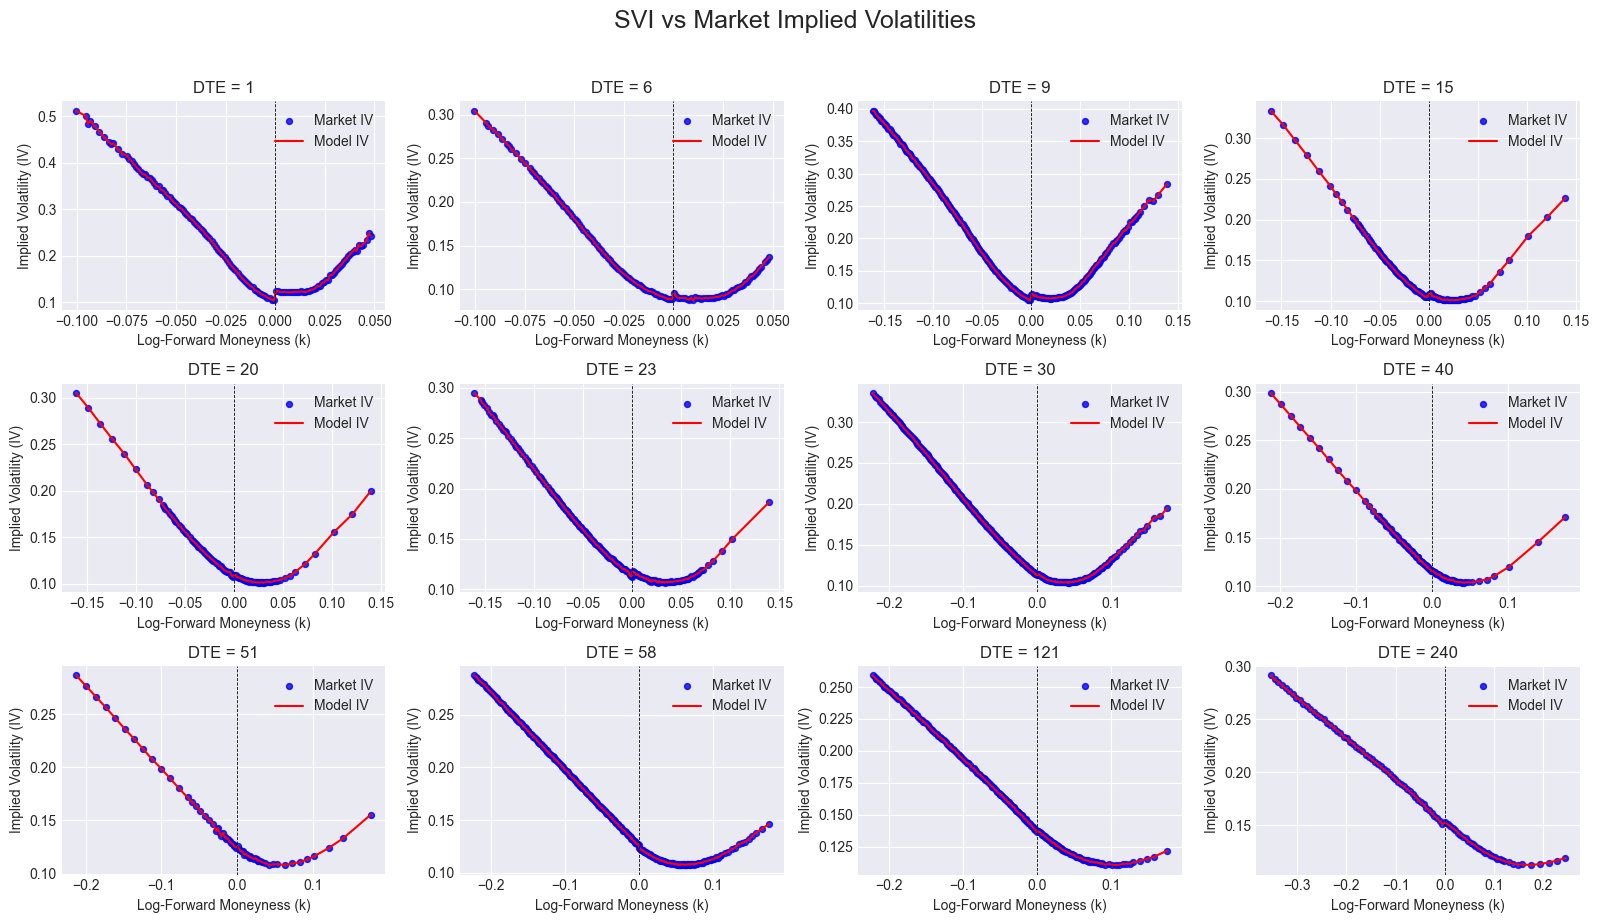

In [56]:
linear_interp.plot_smiles()

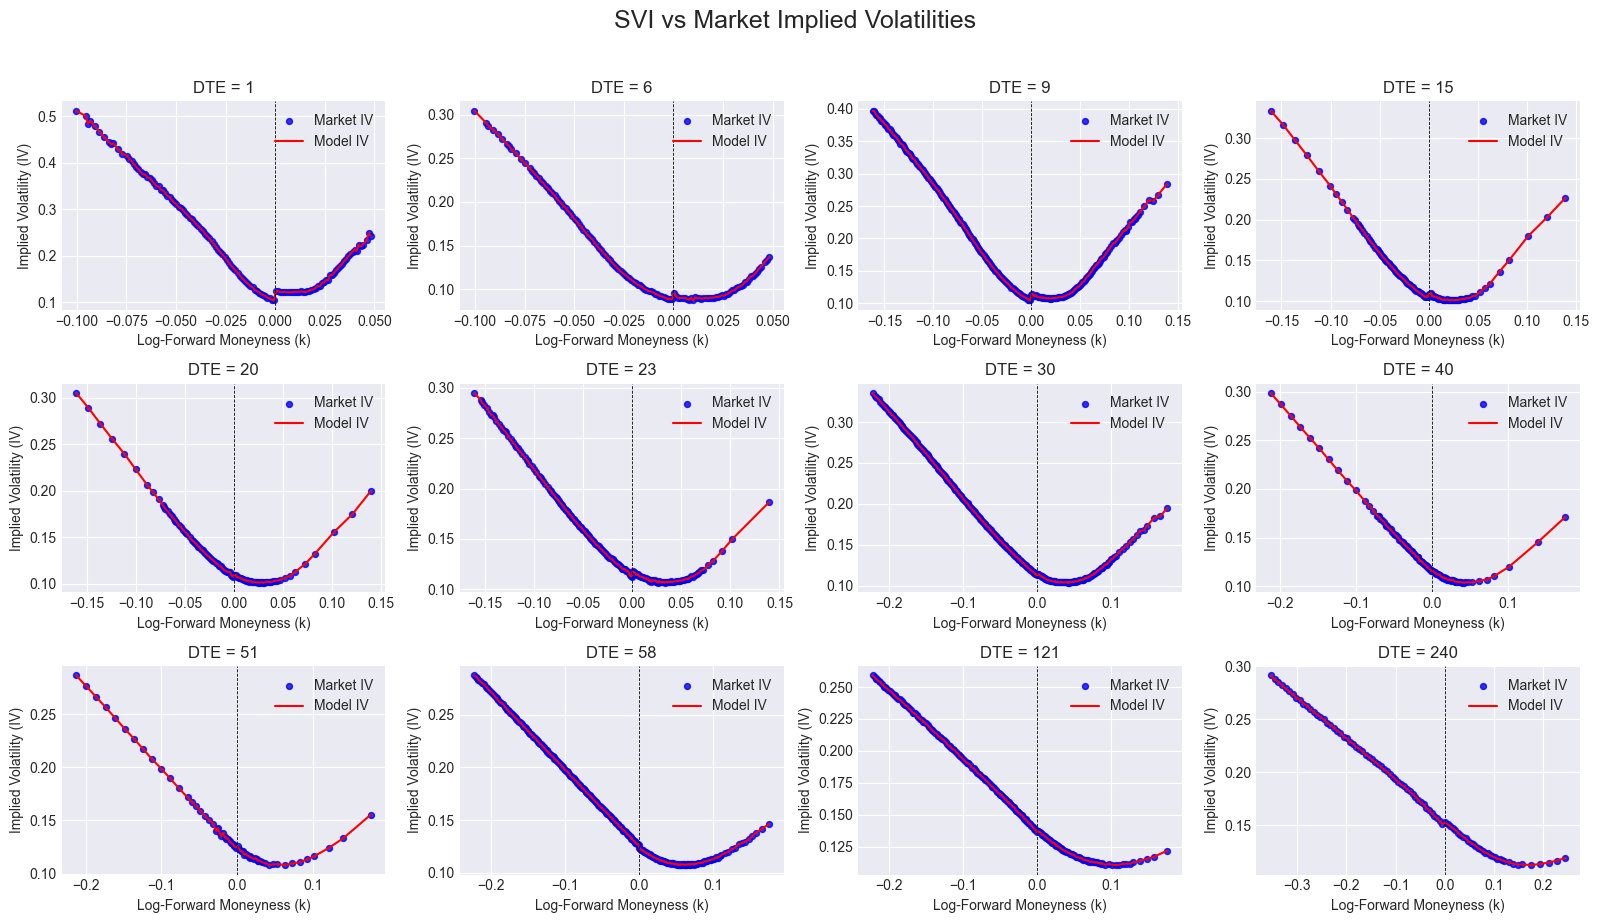

In [57]:
linear_interp.plot_smiles()

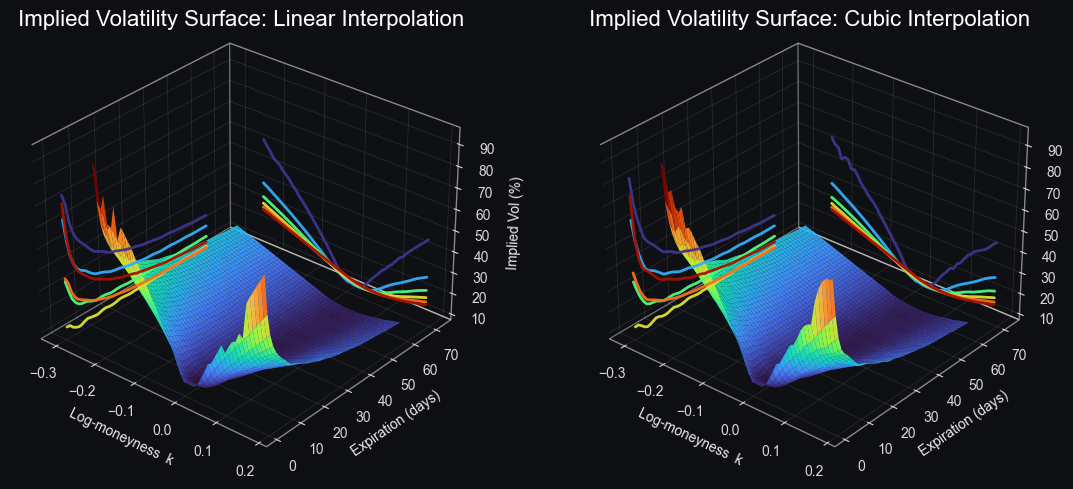

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                         subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': 0.1}
)
fig.patch.set_facecolor("#0e0f12")
linear_interp.plot_iv_surface(ax=axes[0], method_name='Linear Interpolation', colorbar=False)
cubic_interp.plot_iv_surface(ax=axes[1], method_name='Cubic Interpolation', colorbar=False)
plt.show()

# **4. Parametric: Stochastic Volatility Inspired (SVI)**

SVI is a per-maturity (“slice”) parametric smile for **total variance** $w(k,T)=\sigma_{\text{imp}}^2(k,T)\,T$ using the *raw SVI* parametric form, combined with an interpolation across maturities to form a surface.

### **Raw Formula (per slice)**
With log-moneyness $k=\ln(K/S)$,
$$
w(k;\theta)=a + b\left(\rho\,(k-m) + \sqrt{(k-m)^2 + \sigma^2}\right),
$$
where $\theta=(a,b,\rho,m,\sigma)$ controls level ($a$), slope/wing growth ($b$), skew ($\rho$), horizontal shift ($m$), and curvature ($\sigma$).

### **Weighted objective (per maturity $T$)**
Given quotes $\{(k_j,w_j)\}_{j=1}^{n_T}$ and non-negative weights $\omega_j=\omega(k_j,T)$,
$$
\mathcal L_T(\theta_T)
=
\underbrace{\sum_{j=1}^{n_T}\omega_j\big[w_{\theta_T}(k_j)-w_j\big]^2}_{\text{weighted SSE in total variance}}
\;+\;
\underbrace{\lambda_{\text{cal}}
\sum_{u=1}^{U}
\Big(\max\!\big[w_{\theta_{T^-}}(k_u)-w_{\theta_T}(k_u),\,0\big]\,
\mathbf 1_{\{k_u\ge k_{\text{cut}}\}}\Big)^2}_{\text{calendar hinge penalty (optional)}}
\;+\;
\underbrace{\mathbf 1_{\{\text{butterfly infeasible}\}}\cdot M}_{\text{strict butterfly (hard reject)}},
$$
- **Weights $\omega_j$**: heavier near ATM (or uniform), to stabilize the fit where liquidity is highest.  
- **Calendar penalty** (optional): discourages $w(\cdot,T)$ falling below the previous slice on a shared $k$-grid $\{k_u\}$.  
- **Butterfly feasibility**: enforce slice no-arb via inequalities; if violated, reject (large $M$).

### **How we solve it (per slice)**
- **Initialization**: data-driven defaults (ATM level, slope, skew estimate, etc.) plus user overrides.  
- **Local solve**: multiple L-BFGS-B starts with dynamic bounds; pick the best local minimum.  
- **Global fallback (optional)**: differential evolution (DE) over bounds, then L-BFGS-B “polish”, used only if IV-space errors exceed thresholds (e.g., $\text{RMSE}_{\text{IV}}<0.02$, $\max|e_{\text{IV}}|<0.05$ in this notebook).


In [ ]:
class SVI(IVSurfaceModel):
    """
    Per‐slice “raw” SVI with smooth interpolation of parameters across T.
    """
    param_names = ("a", "b", "rho", "m", "sigma")
    def __init__(self,
                 init_guess: dict = None,
                 weight_mode: bool = "atm",
                 butterfly_arb_strict: bool = False,
                 enforce_calendar_arb: bool = False,
                 calendar_arb_weight=50,
                 calendar_arb_kcut=0.02,
                 interpolation_mode=None,  # 'params' or 'w'
                 bounds: dict = None,
                 use_dynamic_init_guess: bool = True,
                 use_dynamic_bounds: bool = True,
                 glob_solver_fallback: bool = True,
                 rmse_iv_recalib: float = 0.02,
                 max_abs_iv_recalib: float = 0.05,
                 maturity_band: tuple = (1/252, 2),
                 min_pts: int = 6,
                 params_interp_kind: str = 'linear'):
        super().__init__()

        # default SVI parameter bounds for raw‐SVI slice calibration
        default_bounds = {
            'a':     (1e-6,   1.0),      # total variance offset
            'b':     (1e-2,   1.0),     # variance slope
            'rho':   (-0.999, 0.999),  # correlation
            'm':     (-1.0,   1.0),   # log-moneyness shift 
            'sigma': (1e-3,   1.0),  # controls smile curvature
        }

        self.init_guess_user = init_guess or {} 
        self.weight_mode = weight_mode # decreasing weights from ATM to OTM
        self.butterfly_arb_strict = butterfly_arb_strict
        self.enforce_calendar_arb = enforce_calendar_arb 
        self.calendar_arb_weight = calendar_arb_weight # strength of penalty
        self.calendar_arb_kcut = calendar_arb_kcut
        self.interpolation_mode = interpolation_mode or (
            'w' if enforce_calendar_arb else 'params'
        )
        self.bounds = bounds or default_bounds
        self.use_dyn = use_dynamic_init_guess
        self.use_dynamic_bounds = use_dynamic_bounds
        self.glob_solver_fallback = glob_solver_fallback
        self.rmse_iv_recalib = rmse_iv_recalib
        self.max_abs_iv_recalib = max_abs_iv_recalib
        self.maturity_band = maturity_band
        self.params_interp_kind  = params_interp_kind
        self.min_pts  = min_pts  # min nb of calib points for the smile

        self.params_by_T  = {}      # raw SVI fits: T -> (a,b,rho,m,sigma)
        self._param_interp = {}    # after fit: name -> interp1d over T
        self.slice_stats = {}     # stores performance metrics per slice 


    # -------- Static helpers --------
    @staticmethod
    def _svi_raw(k, a, b, rho, m, sigma):
        """Raw SVI total‐variance formula:"""
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))
    

    # -------- Public API --------

    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate one raw-SVI slice per quoted maturity and build
        interpolator between slices.
        """
        self._spot = market_data["underlying_last"].iloc[0]

        # ------- prepare dataframe ---------
        df  = self.prepare_iv_surface(market_data)
        df  = df[df["T"].between(*self.maturity_band)].copy()
        self._last_market = df                                  

         # ------- per-slice calibration---------
        T_vals, param_list = [], []
        prev_k = np.linspace(-0.4, 0.4, 61) # common k-grid for calendar test
        prev_params=None

        for T_i, sl in df.groupby("T"):
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            sl = sl[(sl["k"] >= k_lo) & (sl["k"] <= k_hi)]

            if len(sl) < self.min_pts:
                continue

            params = self._calibrate_raw_svi(
                sl["k"].values, sl["w"].values, T_i,
                prev_params=prev_params if self.enforce_calendar_arb else None,
                prev_k=prev_k
            )

            self.params_by_T[T_i] = params
            T_vals.append(T_i)
            param_list.append(params)
            prev_params = params  # update “previous” slice

        if not T_vals:
            raise RuntimeError("No maturities left after filters")

        # ------- unpack parameters----------
        T_grid = np.asarray(T_vals)              # already ascending
        A, B, R, M, S = map(np.array, zip(*param_list))

        # ----------  parameter interpolators -----------------
        self._param_interp = {
            "a"    : interp1d(T_grid, A, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "b"    : interp1d(T_grid, B, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "rho"  : interp1d(T_grid, R, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "m"    : interp1d(T_grid, M, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
            "sigma": interp1d(T_grid, S, kind=self.params_interp_kind,
                            fill_value="extrapolate"),
        }

    def pooled_rmse_iv(self):
        """Pooled RMSE in IV space across all quotes and maturities."""
        if not hasattr(self, "slice_stats") or not self.slice_stats:
            return float("nan")
        N  = np.array([v["n"] for v in self.slice_stats.values()], dtype=float)
        R2 = np.array([v["rmse_iv"]**2 for v in self.slice_stats.values()], dtype=float)
        return float(np.sqrt(np.sum(N * R2) / np.sum(N)))


    # -------- Plotting methods --------
    def plot_params(self, ax=None):
        params = pd.DataFrame.from_dict(
            self.params_by_T,
            orient='index',
            columns=self.param_names
        )
        params.index.name = 'T'
        params = params.sort_index().reset_index()

        if ax is None:
            fig, ax = plt.subplots(figsize=(15, 7))

        for param in self.param_names:
            ax.plot(
                params['T'], params[param],
                marker='o', linestyle='-', label=param, alpha=0.8
            )

        ax.set_title('SVI Parameters vs. Maturity', fontsize=14)
        ax.set_xlabel('T (years)', fontsize=12)
        ax.set_ylabel('Parameter value', fontsize=12)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()

        return ax
    
    def plot_total_variance_slices(self,
                                n_slices: int = 6,
                                k_band: tuple = (-0.2, 0.15),
                                nk: int = 201,
                                show_market: bool = True,
                                ax=None):
        if not self.params_by_T:
            raise RuntimeError("Fit the model first (params_by_T is empty).")

        # maturities sorted (smallest first) and take first n
        Ts = np.array(sorted(self.params_by_T.keys()))
        Ts = Ts[::5][:n_slices]
        kmin, kmax = k_band
        kg = np.linspace(kmin, kmax, nk)

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        ax.axvline(0.0, color='gray', lw=1.0, alpha=0.6)

        for T_i in Ts:
            a,b,rho,m,sigma = self.params_by_T[T_i]
            w_model = self._svi_raw(kg, a,b,rho,m,sigma)
            ax.plot(kg, w_model, lw=2.0, label=fr"T={T_i:.4f} (~{int(round(T_i*252))}d)")

            if show_market and hasattr(self, "_last_market") and self._last_market is not None:
                sl = self._last_market[self._last_market["T"] == T_i]
                if len(sl):
                    mask = (sl["k"] >= kmin) & (sl["k"] <= kmax)
                    sl = sl.loc[mask]
                    ax.scatter(sl["k"], sl["w"], s=10, alpha=0.6)

        ax.set_xlabel(r"Log moneyness $k$")
        ax.set_ylabel("Implied Total Variance")
        ax.legend(title="", fontsize=9)
        ax.grid(True, alpha=0.25)
        plt.tight_layout()
        return ax
    
    def plot_slice_error_metrics(self, ax=None, x_unit="days", as_percent=True,
                                ref_lines=(0.5, 1.0)):
        
        if not self.slice_stats:
            raise RuntimeError("Fit the model first (slice_stats is empty).")

        # Collect and sort by maturity
        Ts = np.array(sorted(self.slice_stats.keys()), dtype=float)  # years
        rmse = np.array([self.slice_stats[T].get("rmse_iv", np.nan) for T in Ts], dtype=float)
        maxabs = np.array([self.slice_stats[T].get("max_abs_iv", np.nan) for T in Ts], dtype=float)

        if x_unit == "days":
            X = Ts * 252.0
            xlab = "DTE (days)"
        elif x_unit == "years":
            X = Ts
            xlab = "T (years)"
        else:
            raise ValueError("x_unit must be 'days' or 'years'")

        # Y as percent if requested
        yscale = 100.0 if as_percent else 1.0
        ylab = "IV error (%)" if as_percent else "IV error (abs.)"

        if ax is None:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, constrained_layout=True)
        else:
            if not isinstance(ax, (list, tuple)) or len(ax) != 2:
                raise ValueError("ax must be a tuple/list of two Axes (top, bottom).")
            ax1, ax2 = ax

        # Top: RMSE
        ax1.plot(X, rmse * yscale, marker="o", lw=1.8, label="RMSE (IV)")
        if ref_lines:
            for r in ref_lines:
                ax1.axhline(r if as_percent else r/100.0, ls="--", lw=0.8, color="gray")
        ax1.set_ylabel(ylab)
        ax1.set_title("Per-slice IV fit errors vs maturity")
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Bottom: Max |error|
        ax2.plot(X, maxabs * yscale, marker="o", lw=1.8, color="C1", label="Max |IV error|")
        if ref_lines:
            for r in ref_lines:
                ax2.axhline(r if as_percent else r/100.0, ls="--", lw=0.8, color="gray")
        ax2.set_xlabel(xlab)
        ax2.set_ylabel(ylab)
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        return ax1, ax2


    # -------- Private helpers --------

    def _default_vector(self, k, w):
        """Return the 5-vector of slice-specific defaults."""
        if self.use_dyn:
            a0 = max(0.0, w.min())
            b0 = min((w.max()-w.min())/ (np.ptp(k)+1e-6), 0.10)
            m0 = k[np.argmin(w)]
            sigma0 = min(np.std(k)*0.1 + 1e-3, 0.10)
            dw_dk = np.gradient(w, k)[np.argmin(np.abs(k))]
            rho0  = np.clip(dw_dk/b0, -0.8, 0.4) if b0>0 else 0.0
        else:                              # static fall-back numbers
            a0, b0, rho0, m0, sigma0 = 0.01, 0.10, 0.0, 0.0, 0.05
        return dict(a=a0, b=b0, rho=rho0, m=m0, sigma=sigma0)

    def _initial_guesses(self, k, w):
        """Yield one np.array per Cartesian combination."""
        base = self._default_vector(k, w)

        # merge user overrides (scalar or iterable)
        param_lists = {}
        for name in self.param_names:
            if name in self.init_guess_user:
                user_val = self.init_guess_user[name]
                param_lists[name] = (user_val if isinstance(user_val,
                                         (list,tuple,np.ndarray))
                                     else [user_val])
            else:
                param_lists[name] = [base[name]]        # single default

        # Cartesian product over only those lists with >1 element
        for combo in itertools.product(*(param_lists[p] for p in self.param_names)):
            yield np.array(combo, float)

    def _slice_objective(self, params: np.ndarray,
                         k: np.ndarray,
                         w: np.ndarray,
                         T: float,
                         prev_params=None,
                         prev_k=None) -> float:
        """
        Objective for one raw‐SVI slice: weighted SSE + optional
        calendar & butterfly arbitrage constraints .
        """
        a, b, rho, m, sigma = params
        model = self._svi_raw(k, a, b, rho, m, sigma)
        resid = model - w

        # -------------  weighted SSE -----------------
        weights = self._weights(k, T)
        sse = float(np.sum(weights * resid**2))

        # ------------- strict butterfly (Ferhani 2020) ----
        if self.butterfly_arb_strict:
            # wing slopes
            C_p, C_m  = b * (rho + 1), b * (rho - 1)
            # intercepts
            D_p, D_m  = a - m * C_p, a - m * C_m
            
            # butterfly check
            ok = (0 < C_p**2 < 4 and 0 < C_m**2 < 4 and
                D_p*(4-D_p) > C_p**2 and D_m*(4-D_m) > C_m**2)
            if not ok:
                return 1e10
            
        # ------------- enforce calendar arbitrage between slices -------
        if self.enforce_calendar_arb and prev_params is not None:
            # evaluate both slices on the shared k-grid
            a0,b0,r0,m0,s0 = prev_params
            w_prev = self._svi_raw(prev_k, a0,b0,r0,m0,s0)
            w_curr = self._svi_raw(prev_k, a ,b ,rho,m ,sigma)

            # hinge: only penalize where current < previous
            viol = np.maximum(w_prev - w_curr, 0.0)

            # focus on the right wing if you want
            if self.calendar_arb_kcut is not None:
                wing_mask = (prev_k >= self.calendar_arb_kcut).astype(float)
                viol *= wing_mask

            # scale-invariant weight
            lam = self.calendar_arb_weight / max(np.mean(w_prev), 1e-8)
            sse += lam * float(np.sum(viol**2))

        return sse
    
    def _weights(self, k, T):
        if self.weight_mode == "uniform":
            return np.ones_like(k)
        if self.weight_mode == "atm" and T <= 0.05:
            return 1.0/(np.abs(k)+0.01)**2
        if self.weight_mode == "atm":
            return 1.0/(np.abs(k)+0.05)
        raise ValueError("weight_mode must be 'uniform'|'atm'")
    
    def _calibrate_raw_svi(self, k, w, T, prev_params=None, prev_k=None):
        lb = np.array([self.bounds[n][0] for n in self.param_names])
        ub = np.array([self.bounds[n][1] for n in self.param_names])

        obj = lambda p: self._slice_objective(
            p, k, w, T,
            prev_params=prev_params,
            prev_k=prev_k
        )

        if self.use_dynamic_bounds:
            ub[0] = 0.5*np.max(w)  # a <= 1/2*max(w)
            lb[3] = 2*np.min(k)    # 2*np.min(k) <= m <= 2*np.max(k)
            ub[3] = 2*np.max(k)
            lb[1] = 1e-2

            if T < 0.05: # ≈ 13 DTE
                lb[3], ub[3] = -0.3, 0.3  # tighter m-bounds 

        # ------------- local solver -------------
        best = None
        for x0 in self._initial_guesses(k, w):
            x0 = np.clip(x0, lb, ub)
            sol = minimize(fun=obj,
                           x0=x0, 
                           bounds=list(zip(lb,ub)),
                           method="L-BFGS-B",
                           options={"maxiter": 1000})
            if sol.success and (best is None or sol.fun < best.fun):
                best = sol

        if best is None:
            raise RuntimeError("SVI slice failed for all initial guesses")
    
        # metrics for local solution
        local_params  = best.x
        local_metrics = self._compute_slice_metrics(k, w, T, local_params)

        # early exit if good enough or no global fallback
        if (not self.glob_solver_fallback) or (
            local_metrics["rmse_iv"] < self.rmse_iv_recalib and
            local_metrics["max_abs_iv"] < self.max_abs_iv_recalib
        ):
            self.slice_stats[T] = local_metrics
            return tuple(local_params)           

        # ------------- global DE + polish  -----------
        de = differential_evolution(
            obj,
            bounds=list(zip(lb,ub)),
            strategy='best1bin', popsize=15, maxiter=150,
            tol=1e-6,  mutation =(0.5, 1.0), recombination=0.7, 
            polish=False, # we'll polish ourselves
            disp=False,
            updating ='deferred' # faster in recent SciPy versions
        )
        pol = minimize(
            fun=obj,
            x0=de.x, 
            bounds=list(zip(lb,ub)),
            method='L-BFGS-B', options={'maxiter':500}
        )

        # choose final by objective value (and compute metrics for it)
        if pol.success and pol.fun < best.fun:
            final_params  = pol.x
            final_metrics = self._compute_slice_metrics(k, w, T, final_params)
        else:
            final_params  = local_params
            final_metrics = local_metrics

        self.slice_stats[T] = final_metrics
        return tuple(final_params)

    def _w_between_slices(self, k: np.ndarray, T: np.ndarray, atol=1e-10):
        """
        Calendar-safe interpolation of total variance in T between raw-SVI slices.
        """
        k = np.atleast_1d(k).astype(float)
        Tq = np.atleast_1d(T).astype(float)

        # sorted slices and params
        Ts = np.array(sorted(self.params_by_T.keys()))
        if Ts.size < 2:
            raise RuntimeError("Need at least two calibrated slices to interpolate in T.")
        
        # for each query T, find bracketing indices
        idx = np.searchsorted(Ts, Tq, side="right") - 1
        idx = np.clip(idx, 0, len(Ts)-2)
        T0 = Ts[idx]
        T1 = Ts[idx+1]

        # snap-to-knot: if T is (numerically) exactly a slice, evaluate that slice
        exact0 = np.isclose(Tq, T0, atol=atol)
        exact1 = np.isclose(Tq, T1, atol=atol)

        lam = (Tq - T0) / (T1 - T0 + 1e-16)
        lam = np.maximum(lam, 0.0) # clamp to 0 below T0 and linear to T above T1

        # gather parameters for both slices
        P0 = np.array([self.params_by_T[t] for t in T0]) # (nT, 5)
        P1 = np.array([self.params_by_T[t] for t in T1])

        # evaluate both slices on the same k-mesh
        K, _ = np.meshgrid(k, Tq, indexing="xy") # (nT, nK)
        A0,B0,R0,M0,S0 = (P0[:,0,None], P0[:,1,None], P0[:,2,None], P0[:,3,None], P0[:,4,None])
        A1,B1,R1,M1,S1 = (P1[:,0,None], P1[:,1,None], P1[:,2,None], P1[:,3,None], P1[:,4,None])
        W0 = self._svi_raw(K, A0, B0, R0, M0, S0)
        W1 = self._svi_raw(K, A1, B1, R1, M1, S1)
        W  = (1.0 - lam)[:,None]*W0 + lam[:,None]*W1 # (nT, nK)

        # Overwrite exact rows with the exact slice evaluation (no FP drift)
        if exact0.any():
            rows = np.where(exact0)[0]
            for r in rows:
                W[r,:] = self._svi_raw(k, *self.params_by_T[T0[r]])
        if exact1.any():
            rows = np.where(exact1)[0]
            for r in rows:
                W[r,:] = self._svi_raw(k, *self.params_by_T[T1[r]])

        return W

    def _implied_total_variance(self, k, T):
        k = np.atleast_1d(k).astype(float)
        T = np.atleast_1d(T).astype(float)

        if self.interpolation_mode == 'params': # could use PCHIP instead
            # classic: interpolate a,b,rho,m,sigma then evaluate raw SVI
            a = self._param_interp['a'](T); b = self._param_interp['b'](T)
            rho = self._param_interp['rho'](T); m = self._param_interp['m'](T)
            sig = self._param_interp['sigma'](T)
            K,_ = np.meshgrid(k, T, indexing='xy')
            return self._svi_raw(K, a[:,None], b[:,None], rho[:,None], m[:,None], sig[:,None])

        elif self.interpolation_mode == 'w':
            # calendar-safe: piecewise-linear blend of w(k,T) between slices
            return self._w_between_slices(k, T)

        else:
            raise ValueError("interpolation_mode must be 'params' or 'w'")
        
    def _compute_slice_metrics(self, k, w, T, params):
        """Compute IV / w errors for a slice and return a dict."""
        a,b,rho,m,sigma = params
        w_model  = self._svi_raw(k, a,b,rho,m,sigma)

        # guard small T
        T_eff    = max(float(T), 1e-16)
        sig_mkt  = np.sqrt(np.maximum(w, 0.0) / T_eff)
        sig_mdl  = np.sqrt(np.maximum(w_model, 0.0) / T_eff)

        err_iv   = sig_mkt - sig_mdl
        err_w    = w - w_model

        metrics = dict(
            n        = len(k),
            rmse_iv  = float(np.sqrt(np.mean(err_iv**2))),
            max_abs_iv= float(np.max(np.abs(err_iv))),
            rmse_w   = float(np.sqrt(np.mean(err_w**2))),
        )
        return metrics

## **4.1. Optimization with Single vs Multiple Initial Conditions**

Here we test the difference between using a single initial guess and multiple initial guesses when calibrating SVI slices. The idea is that the SVI calibration problem is **non-linear** and the objective function is **not convex**, so local minima are common.  

Because of this, the performance of the fit can be highly sensitive to the starting point. Multiple initial conditions increase the chance of finding a better optimum, at the cost of additional computation time.

In [60]:
single_init = {"rho": [0.0]}
multiple_init = {"rho": [-0.7, -0.5, -0.3, -0.1, 0.0]}

svi_sing = SVI(init_guess=single_init, glob_solver_fallback=False)
svi_mult = SVI(init_guess=multiple_init, glob_solver_fallback=False)

svi_sing.fit(options_red)
svi_mult.fit(options_red)

print(f"Pooled RMSE of IV with Single initial conditions: {round(svi_sing.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with Multiple initial conditions: {round(svi_mult.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV with Single initial conditions: 1.36 %
Pooled RMSE of IV with Multiple initial conditions: 0.87 %


In [61]:
svi_sing.plot_smiles()

In [62]:
svi_mult.plot_smiles()

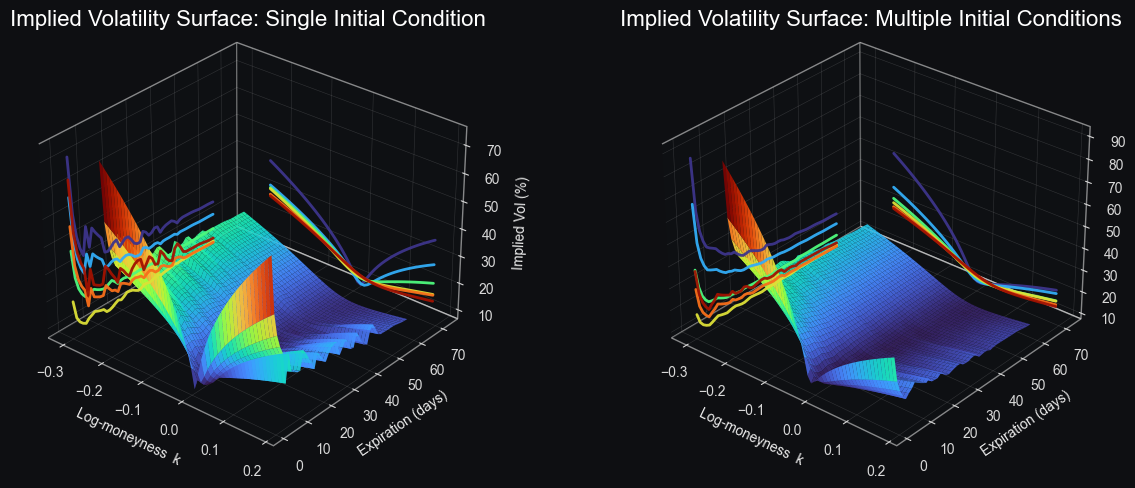

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                         subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': 0.35}
)
fig.patch.set_facecolor("#0e0f12")
svi_sing.plot_iv_surface(ax=axes[0], method_name='Single Initial Condition', colorbar=False)
svi_mult.plot_iv_surface(ax=axes[1], method_name='Multiple Initial Conditions', colorbar=False)
plt.show()

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
svi_sing.plot_slice_error_metrics(ax=axes[0].tolist())
svi_mult.plot_slice_error_metrics(ax=axes[1].tolist())
plt.show()

In [65]:
svi_sing.plot_params()
plt.show()

With a **single initial condition** ($\rho = 0$), the optimization got trapped in local minima, leaving some maturities with the fitted $\rho$ equal to the initial guess.

In [66]:
svi_mult.plot_params()
plt.show()

With **multiple initial conditions**, the fit is less prone to local minima, and **$\rho$ now decreases with $T$**, matching the expected skew term structure for index equity options.

## **4.2. Local solver without / with global solver fallback**

Earlier, we saw that using multiple initial conditions can significantly improve the fit compared to a single start.  
However, for shorter maturities, the optimizer may still fail to reach the global minimum because the smile is harder to fit than for larger $T$.  

In such cases, a **global solver** (e.g., differential evolution) can be used as a fallback when:
- $\text{RMSE}_{\text{IV}} > 2\%$, or
- $\max|e_{\text{IV}}| > 5\%$

This second pass uses a more exploratory search over the parameter space, followed by a local “polish,” to find more promising regions and refine the fit.


In [67]:
svi_loc = SVI(init_guess=multiple_init,glob_solver_fallback=False)
svi_loc_fallback = SVI(init_guess=multiple_init, glob_solver_fallback=True)

svi_loc.fit(options_red)
svi_loc_fallback.fit(options_red)

print(f"Pooled RMSE of IV with Local solver only: {round(svi_loc.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with Local solver + global solver: {round(svi_loc_fallback.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV with Local solver only: 0.87 %
Pooled RMSE of IV with Local solver + global solver: 0.86 %


In [68]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
svi_loc.plot_slice_error_metrics(ax=axes[0].tolist())
svi_loc_fallback.plot_slice_error_metrics(ax=axes[1].tolist())
plt.show()

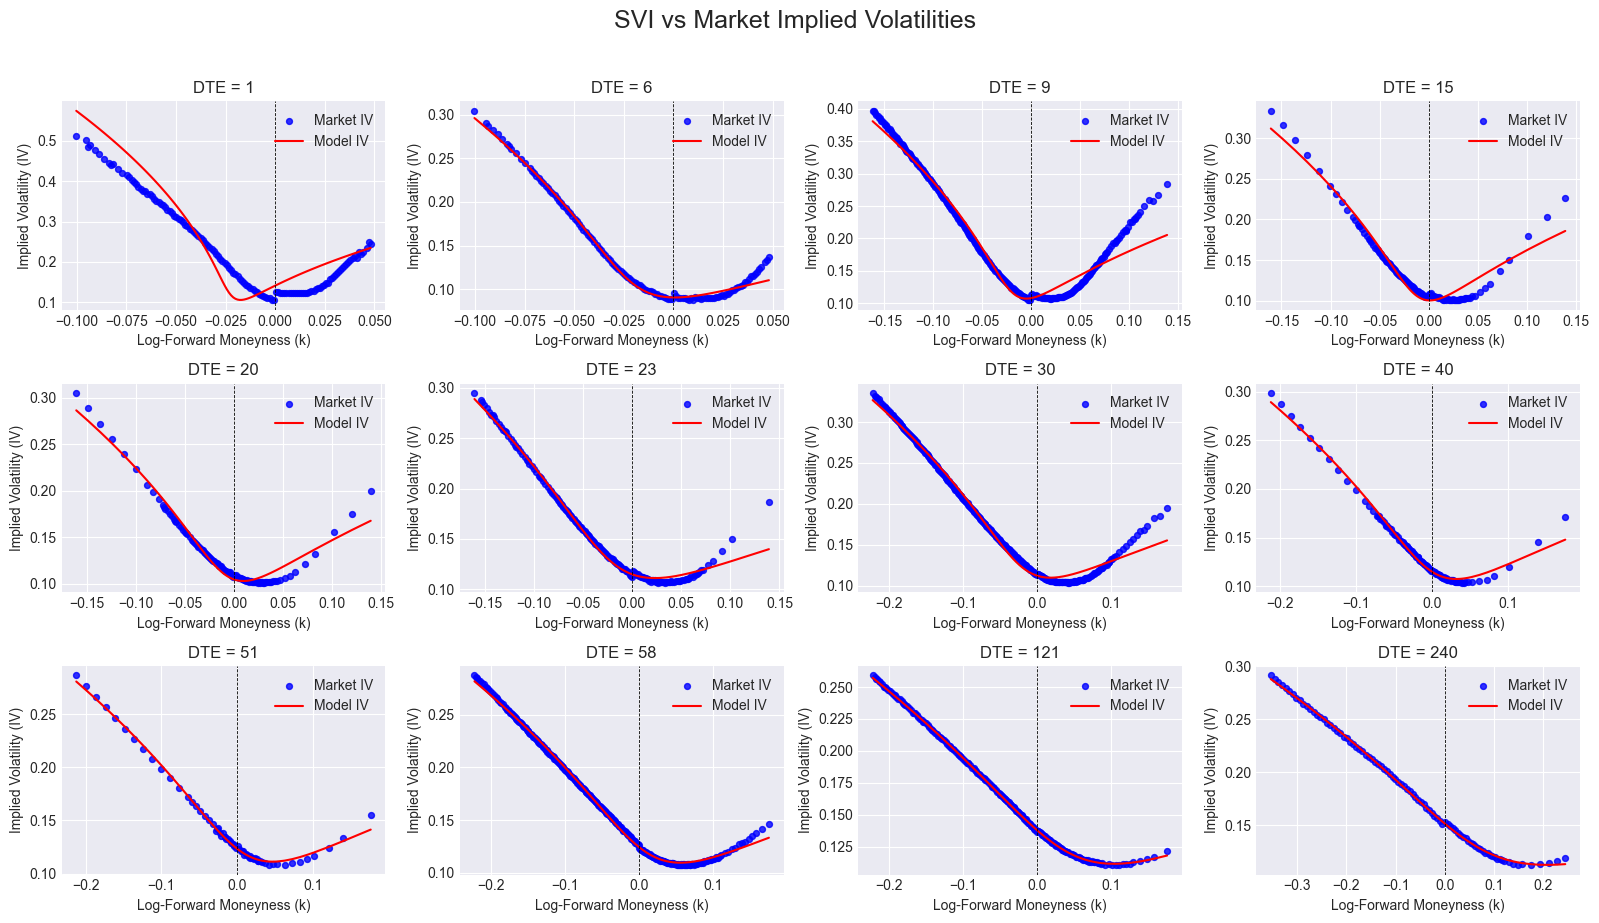

In [69]:
svi_loc.plot_smiles()

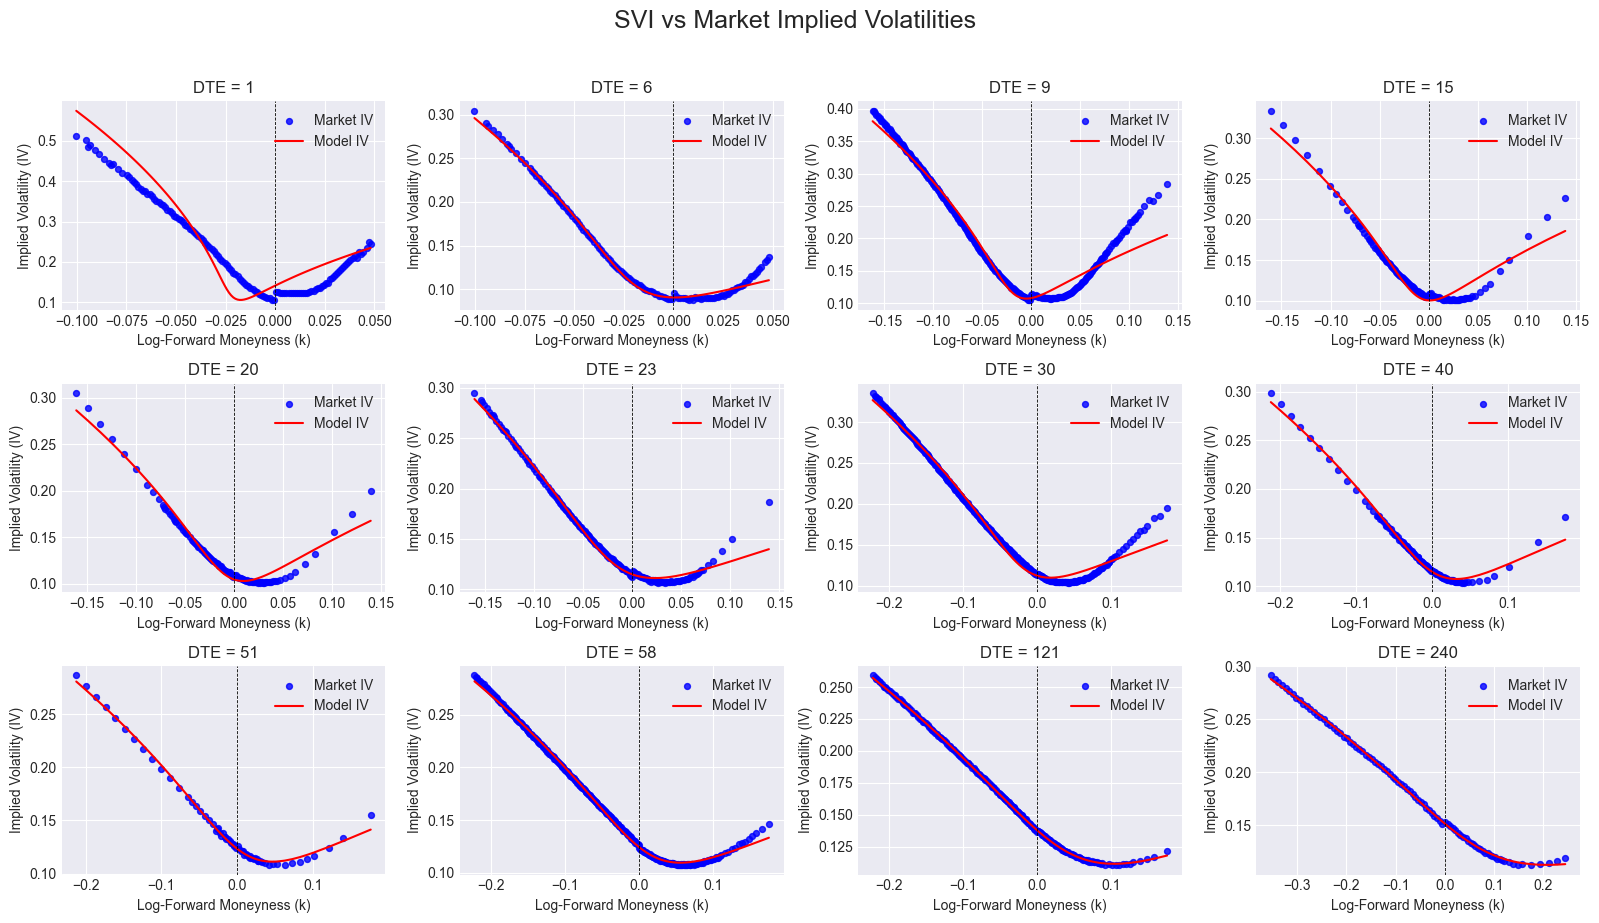

In [70]:
svi_loc_fallback.plot_smiles()

Both methods fit the smiles similarly, except for the **1-DTE slice**, where the global solver provides a clear improvement.

## **4.3. Unconstrained vs Calendar Arbitrage Penalty**

Since the SVI formula fits each maturity slice independently, it does not guarantee **calendar arbitrage** consistency between slices.  
A calendar arbitrage occurs when the total implied variance is not monotonic with respect to time to maturity $T$.  

Formally, an SVI surface is **calendar-arbitrage-free** if:
$$
w_{T_{i+1}}(k) \geq w_{T_i}(k) \quad \text{for all } T_i \text{ in the option chain}.
$$

We compare two calibration approaches:
1. **Unconstrained** — minimize weighted SSE per slice, ignoring calendar monotonicity.
2. **With penalty** — add a hinge penalty to the objective to discourage $w(k, T)$ from decreasing with $T$:
$$
\text{Penalty} = \lambda_{\text{cal}}
\sum_{u} \max\!\big[w(k_u, T_{\text{prev}}) - w(k_u, T),\, 0\big]^2 \cdot \mathbf 1_{\{k_u \ge k_{\text{cut}}\}}.
$$

**Objective:** Evaluate the trade-off between fit quality (pooled IV RMSE) and reduction of calendar violations.

In [71]:
init_guess = {"rho": [ -0.7, -0.5, -0.3, -0.1, 0.0]}
soft_cal_arb_weight = 50
hard_cal_arb_weight = 200

svi_unc = SVI(init_guess=init_guess, enforce_calendar_arb=False)
svi_cal_soft = SVI(init_guess=init_guess, enforce_calendar_arb=True, calendar_arb_weight=soft_cal_arb_weight)
svi_cal_hard = SVI(init_guess=init_guess, enforce_calendar_arb=True, calendar_arb_weight=hard_cal_arb_weight)

svi_unc.fit(options_red)
svi_cal_soft.fit(options_red)
svi_cal_hard.fit(options_red)

print(f"Pooled RMSE of IV Without Calendar arbitrage penalty: {round(svi_unc.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV With Soft Calendar arbitrage penalty: {round(svi_cal_soft.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV With Hard Calendar arbitrage penalty: {round(svi_cal_hard.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV Without Calendar arbitrage penalty: 0.86 %
Pooled RMSE of IV With Soft Calendar arbitrage penalty: 0.81 %
Pooled RMSE of IV With Hard Calendar arbitrage penalty: 0.89 %


In [72]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
svi_unc.plot_total_variance_slices(ax=axes[0])
svi_cal_soft.plot_total_variance_slices(ax=axes[1])
svi_cal_hard.plot_total_variance_slices(ax=axes[2])
axes[0].set_title("Unconstrained")
axes[1].set_title(fr"Soft Calendar arbitrage penalty $\lambda = {soft_cal_arb_weight}$")
axes[2].set_title(fr"Hard Calendar arbitrage penalty $\lambda = {hard_cal_arb_weight}$")
plt.show()

Without any calendar-arbitrage penalty, the total implied variance curves for **34** and **42 DTE** intersect at $k = 10$.
In contrast, when the calendar-arbitrage penalty is applied, the curves no longer intersect, even though the raw market data itself contains calendar-arbitrage violations.

In [73]:
svi_unc.check_arbitrage()

type         T         k     value
0     calendar  0.021492  0.172025 -0.000025
1     calendar  0.021492  0.191668 -0.000278
2     calendar  0.021492  0.211311 -0.000520
3     calendar  0.021492  0.230954 -0.000754
4     calendar  0.021492  0.250598 -0.000981
...        ...       ...       ...       ...
3912  calendar  1.805889  0.643462 -0.032481
3913  calendar  1.805889  0.663105 -0.034570
3914  calendar  1.805889  0.682748 -0.036641
3915  calendar  1.805889  0.702391 -0.038695
3916  calendar  1.805889  0.722035 -0.040732

[3917 rows x 4 columns]

In [74]:
svi_cal_soft.check_arbitrage()

type         T         k     value
0     calendar  0.005952 -3.206607 -0.148375
1     calendar  0.005952 -3.186964 -0.146936
2     calendar  0.005952 -3.167320 -0.145497
3     calendar  0.005952 -3.147677 -0.144058
4     calendar  0.005952 -3.128034 -0.142619
...        ...       ...       ...       ...
2965  calendar  1.805889  0.643462 -0.017483
2966  calendar  1.805889  0.663105 -0.018699
2967  calendar  1.805889  0.682748 -0.019896
2968  calendar  1.805889  0.702391 -0.021077
2969  calendar  1.805889  0.722035 -0.022242

[2970 rows x 4 columns]

In [75]:
svi_cal_hard.check_arbitrage()

type         T         k     value
0     calendar  0.053572 -3.206607 -1.363971
1     calendar  0.053572 -3.186964 -1.355202
2     calendar  0.053572 -3.167320 -1.346434
3     calendar  0.053572 -3.147677 -1.337666
4     calendar  0.053572 -3.128034 -1.328897
...        ...       ...       ...       ...
3490  calendar  1.805889  0.643462 -0.016275
3491  calendar  1.805889  0.663105 -0.017387
3492  calendar  1.805889  0.682748 -0.018480
3493  calendar  1.805889  0.702391 -0.019557
3494  calendar  1.805889  0.722035 -0.020618

[3495 rows x 4 columns]

Using a calendar-arbitrage penalty, we have effectively reduced the number of calendar-arbitrage violations. However, this does not guarantee that the interpolated surface itself is entirely calendar-arbitrage-free.

## **4.4. Interpolation in parameter vs total variance space**

In [76]:
svi_params_interp = SVI(init_guess=multiple_init, interpolation_mode="params", enforce_calendar_arb=True)
svi_w_interp = SVI(init_guess=multiple_init, interpolation_mode="w", enforce_calendar_arb=True)

svi_params_interp.fit(options_red)
svi_w_interp.fit(options_red)

print(f"Pooled RMSE of IV with Single initial conditions: {round(svi_params_interp.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with Multiple initial conditions: {round(svi_w_interp.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV with Single initial conditions: 0.88 %
Pooled RMSE of IV with Multiple initial conditions: 0.89 %


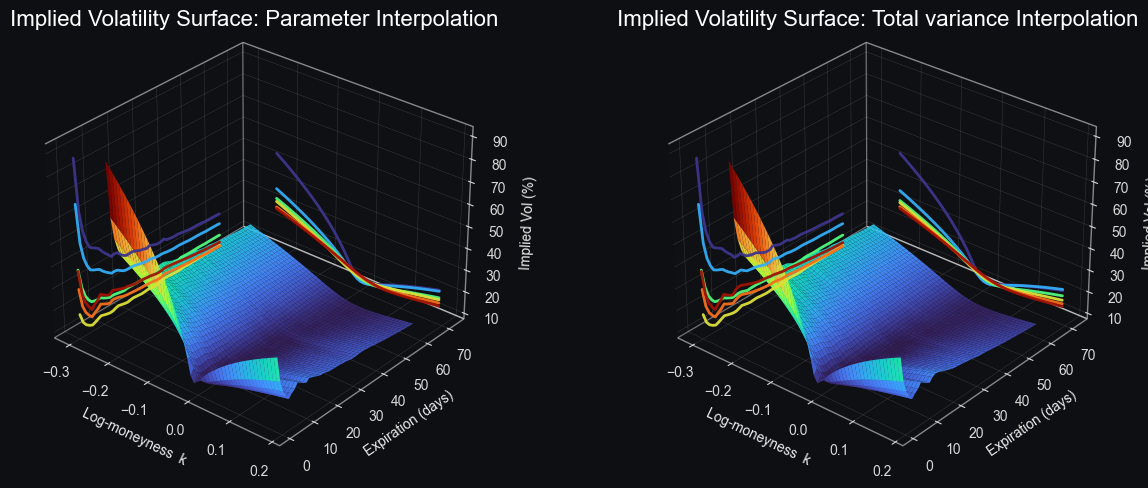

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                         subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': 0.35}
)
fig.patch.set_facecolor("#0e0f12")
svi_params_interp.plot_iv_surface(ax=axes[0], method_name='Parameter Interpolation', colorbar=False)
svi_w_interp.plot_iv_surface(ax=axes[1], method_name='Total variance Interpolation', colorbar=False)
plt.show()

In [78]:
svi_params_interp.check_arbitrage()

type         T         k     value
0     calendar  0.021492  0.191668 -0.000157
1     calendar  0.021492  0.211311 -0.000388
2     calendar  0.021492  0.230954 -0.000609
3     calendar  0.021492  0.250598 -0.000825
4     calendar  0.021492  0.270241 -0.001035
...        ...       ...       ...       ...
3439  calendar  1.805889  0.643462 -0.016464
3440  calendar  1.805889  0.663105 -0.017722
3441  calendar  1.805889  0.682748 -0.018961
3442  calendar  1.805889  0.702391 -0.020181
3443  calendar  1.805889  0.722035 -0.021385

[3444 rows x 4 columns]

In [79]:
svi_w_interp.check_arbitrage()

type         T         k     value
0     calendar  0.053572 -3.206607 -1.839256
1     calendar  0.053572 -3.186964 -1.827499
2     calendar  0.053572 -3.167320 -1.815742
3     calendar  0.053572 -3.147677 -1.803985
4     calendar  0.053572 -3.128034 -1.792228
...        ...       ...       ...       ...
3321  calendar  1.805889  0.643462 -0.017445
3322  calendar  1.805889  0.663105 -0.018658
3323  calendar  1.805889  0.682748 -0.019852
3324  calendar  1.805889  0.702391 -0.021030
3325  calendar  1.805889  0.722035 -0.022192

[3326 rows x 4 columns]

Since there ar eless calendar arbitrage penalty between slices, the interpolation in total variance space significantly reduces the calendar arbitrage opportunties comapre to interpoaltion in parameters.

## **4.5. Uniform vs ATM Weighting with Time Adjustment**

In the SVI slice calibration, each quote $(k, w)$ is assigned a weight to control its influence on the objective function.  
We compare two weighting schemes:

### **1. Uniform weighting**  
   $$
   \omega(k, T) = 1
   $$
   All strikes receive equal importance regardless of moneyness or time to maturity.

### **2. ATM-focused weighting (time-adjusted)**  
   For **very short maturities** ($T \le 0.05$ years ≈ 13 DTE):
   $$
   \omega(k, T) = \frac{1}{(|k| + 0.01)^2}
   $$
   For **longer maturities**:
   $$
   \omega(k, T) = \frac{1}{|k| + 0.05}
   $$
   This emphasises quotes near the money ($k \approx 0$), where liquidity is higher and accuracy is more critical for hedging and quoting.  
   The steeper decay for short maturities further penalises deep OTM points, which are often noisy and harder to fit in short-term smiles.

### **Goal of the comparison:**  
- **Uniform weighting** tends to fit the wings and ATM equally, which can dilute accuracy at the most liquid strikes.  
- **ATM weighting** improves ATM fit at the potential cost of worse wing fit. The time adjustment sharpens this effect for short maturities, where precise ATM calibration is especially important.

In [80]:
svi_unif = SVI(init_guess=multiple_init, weight_mode="uniform")
svi_atm = SVI(init_guess=multiple_init, weight_mode="atm")

svi_unif.fit(options_red)
svi_atm.fit(options_red)

print(f"Pooled RMSE of IV with Uniform weights: {round(svi_unif.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with ATM weights: {round(svi_atm.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV with Uniform weights: 0.84 %
Pooled RMSE of IV with ATM weights: 0.80 %


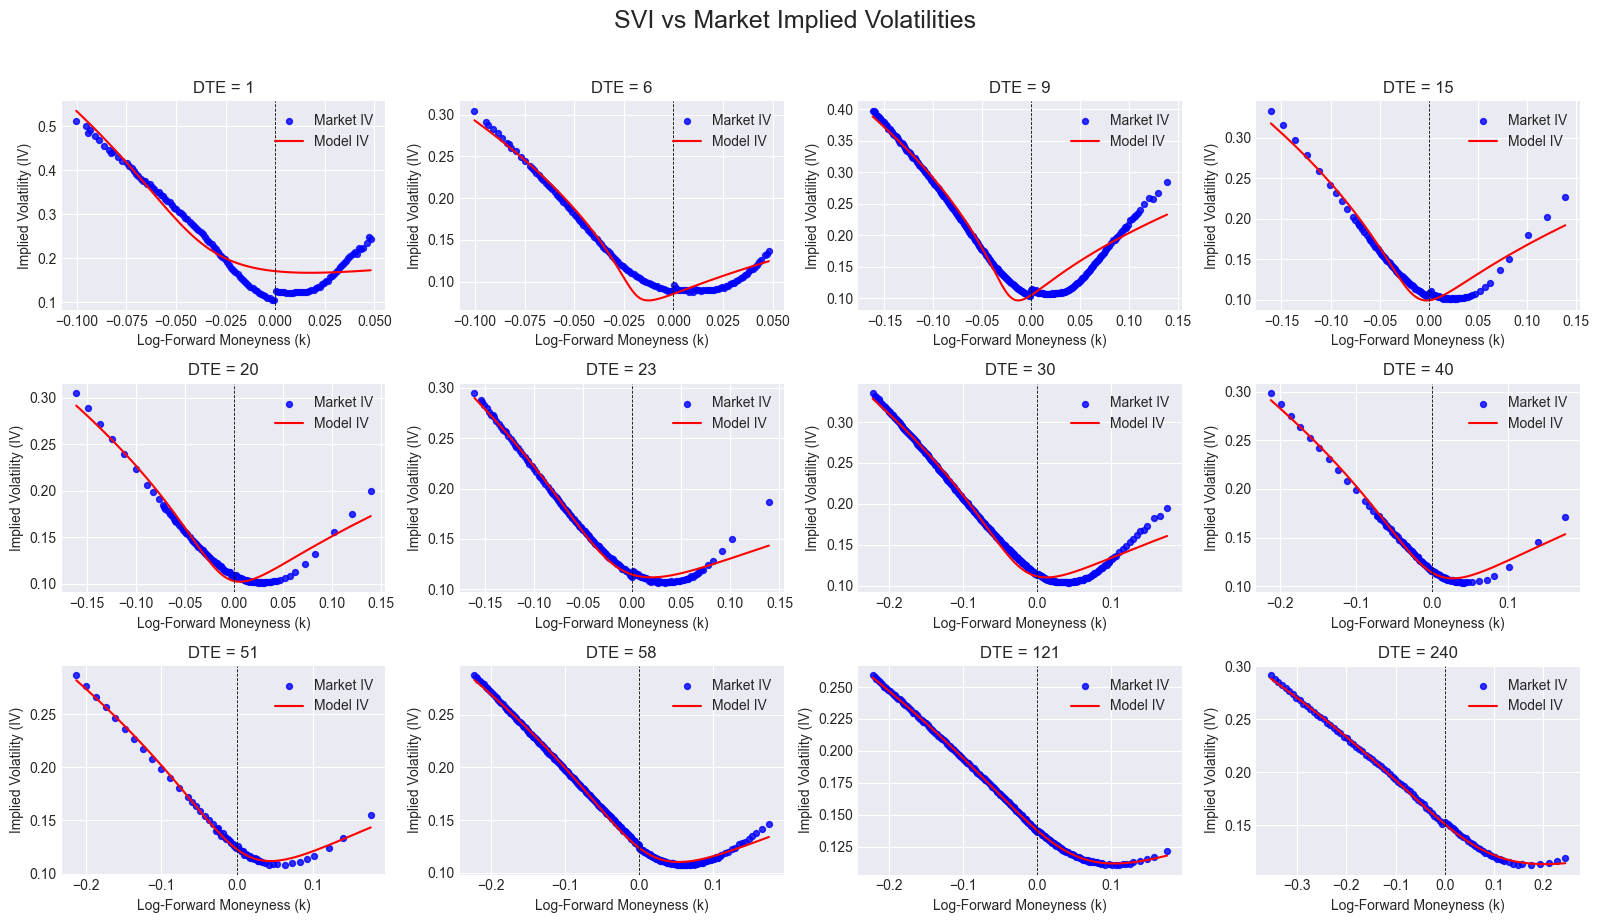

In [81]:
svi_unif.plot_smiles()

Uniform weights clearly **underfit short maturity smiles** however for larger maturities it fits the smile pretty well.

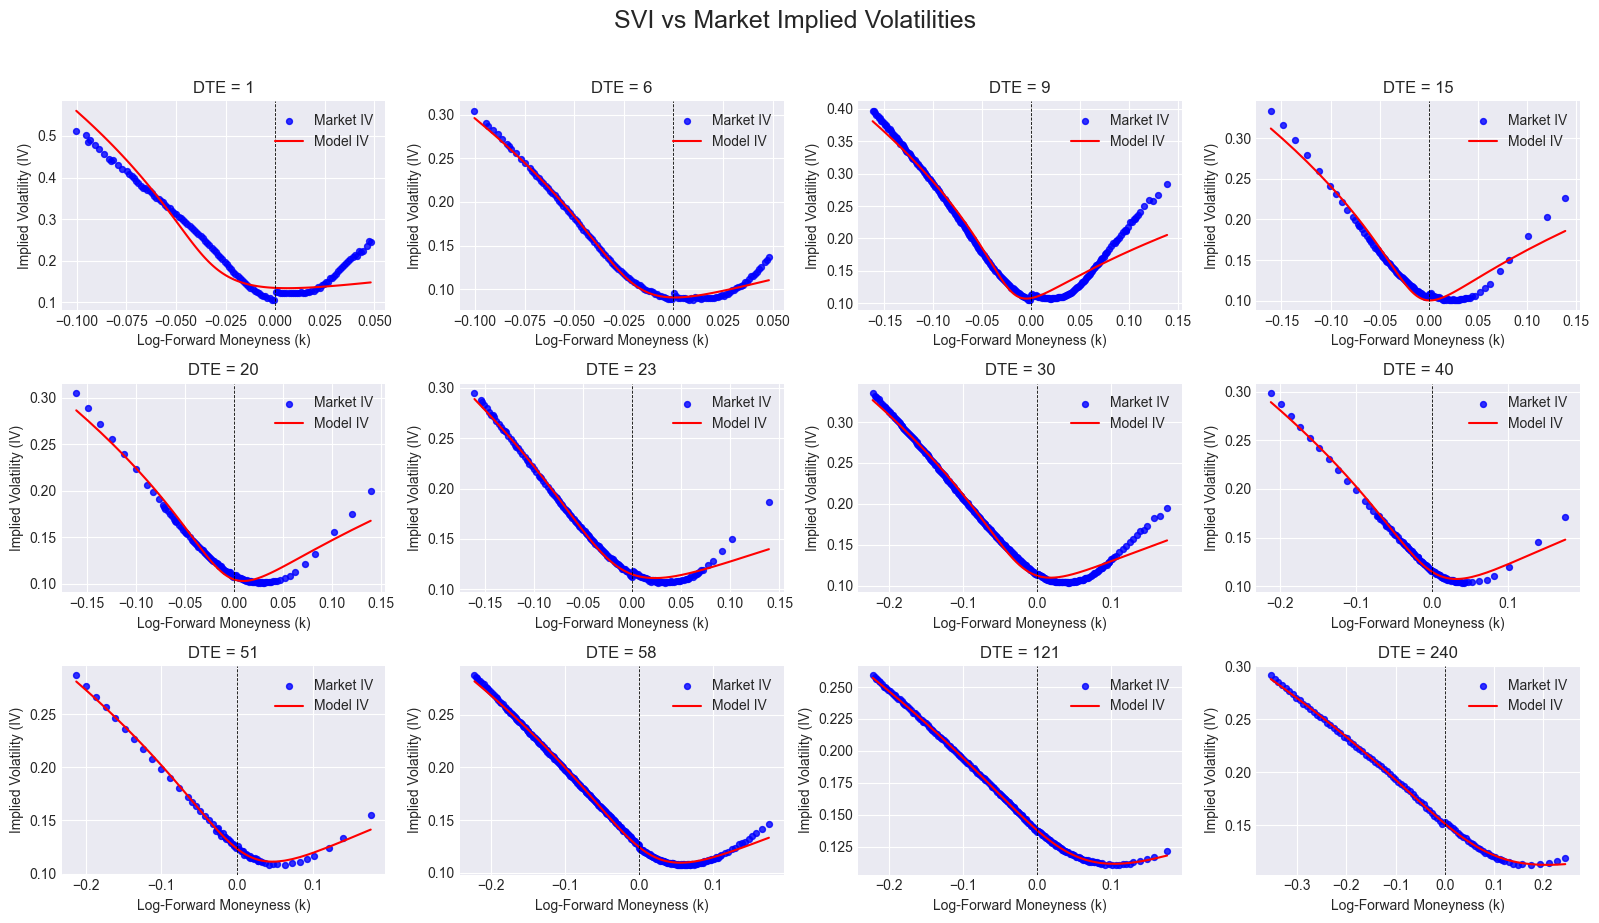

In [82]:
svi_atm.plot_smiles()

Now ATM weighting where weights are more imporant near ATM fits the smile much better than uniform weighting.

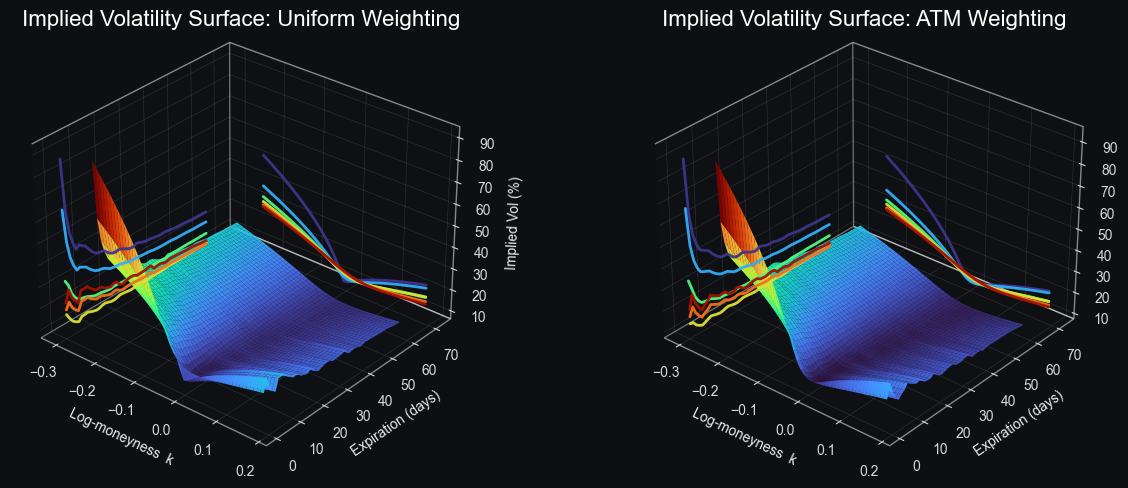

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6),
                         subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': 0.35}
)
fig.patch.set_facecolor("#0e0f12")
svi_unif.plot_iv_surface(ax=axes[0], method_name='Uniform Weighting', colorbar=False)
svi_atm.plot_iv_surface(ax=axes[1], method_name='ATM Weighting', colorbar=False)
plt.show()

# **5. Parametric extensions: xSSVI Family (SSVI & eSSVI)**

SSVI and eSSVI extend the SVI idea by fitting a *joint* parametric surface for **total variance**  
$$
w(k,T) = \sigma_{\text{imp}}^2(k,T)\,T
$$  

### **Raw Formula**
With log-moneyness $k = \ln(K/S)$ and $\theta = \theta(T)$,  
$$
w(k,\theta) = \frac{\theta}{2} \left[ 1 + \rho(\theta) \,\phi(\theta)\,k \;+\; \sqrt{ \big(\phi(\theta)k + \rho(\theta)\big)^2 + 1 - \rho(\theta)^2 } \right],
$$  
where:  
- $\theta(T)$: ATM total variance term-structure (monotone interpolated from per-slice estimates)  
- $\phi(\theta) = \eta \,\theta^{-\gamma}$: vol-of-vol function  
- $\rho(\theta)$: skew function, constant in SSVI, $\theta$-dependent in eSSVI  
- Parameters $(\eta,\gamma, \rho_c, \rho_s, \alpha)$ depend on the chosen model  

### **Weighted Objective (global, across maturities)**
Given all quotes $\{(k_i,T_i,w_i)\}_{i=1}^N$ and weights $\omega_i = \omega(k_i, \theta(T_i))$:  
$$
\mathcal L(\psi) =
\underbrace{\sum_{i=1}^N \omega_i \,\big[w_\psi(k_i,\theta(T_i)) - w_i\big]^2}_{\text{weighted SSE in total variance}}
\;+\;
\underbrace{\mathbf 1_{\{\text{butterfly infeasible}\}}\cdot M}_{\text{strict butterfly reject}},
$$  
where $\psi$ is the full set of model parameters (common to all maturities).  

- **Weights $\omega_i$**: uniform, ATM-heavy, or ATM+$\theta$-scaled.  
- **Butterfly penality**: enforce slice no-arb inequalities using mathematical sufficient conditions.  

All subclasses of `xSSVI` below must implement the `_w` and `_objective` methods, which compute the total implied variance and the objective function, respectively.

In [ ]:
class xSSVI(IVSurfaceModel):
    """Intermediary abstract class for SSVI and eSSVI.
    Need to define the virtual method _objective and _w"""
    def __init__(self,
                 weight_mode: str = "atm",
                 butterfly_arb_strict: bool = False,
                 maturity_band : tuple = (1/252, 2),
                 moneyness_band: tuple = (0.75, 1.25),
                 min_pts: int = 6
        ):
        super().__init__()
        self.butterfly_arb_strict = butterfly_arb_strict
        self.weight_mode = weight_mode
        self.maturity_band  = maturity_band
        self.moneyness_band = moneyness_band
        self.min_pts = min_pts

        self.theta_interp = None
        self.params = None # Store parameters of SSVi or eSSVI
        self.bounds = None

    @staticmethod
    @abstractmethod
    def _w(k, theta, params):
        pass
    
    @abstractmethod
    def _objective(self, k, theta, w, weights, params):
        pass

    @staticmethod
    def _phi(theta, eta, gamma):
        return eta * theta**(-gamma)

    def fit(self, market_data: pd.DataFrame) -> None:
        self._spot = market_data["underlying_last"].iloc[0]
        df = self.prepare_iv_surface(market_data)

        # ------- log moneyness and maturity filters -------
        tmin, tmax = self.maturity_band
        df = df[df["T"].between(tmin, tmax)]
        mlo, mhi = self.moneyness_band
        klo, khi = np.log(mlo), np.log(mhi)
        df = df[df["k"].between(klo, khi)]
        if self.min_pts > 0:
            df = df.groupby("T").filter(lambda g: len(g) >= self.min_pts)

        if df.empty:
            raise RuntimeError("No quotes after filters")
        self._last_market = df.copy()

        # ------ θ̂(T): ATM quadratic intercept per slice, then PCHIP & make monotone -----
        groups = {T: g for T, g in df.groupby("T")}
        T_grid = np.array(sorted(groups.keys()))
        theta_hat = []
        for T in T_grid:
            g = groups[T]
            th = self._estimate_theta_slice(g["k"].to_numpy(), g["w"].to_numpy())
            theta_hat.append(th)    
        theta_hat = np.asarray(theta_hat, float)
        theta_hat  = np.maximum.accumulate(theta_hat)                 # monotone
        self.theta_interp = PchipInterpolator(T_grid, theta_hat, extrapolate=True)

        # ------- stack quotes ------
        k_all = df["k"].to_numpy()
        T_all = df["T"].to_numpy()
        w_all = df["w"].to_numpy()
        theta_all = self.theta_interp(T_all)
        weights = self._weights(k_all, theta_all)

        # cache θ range for constraints
        self._theta_min = float(theta_all.min())
        self._theta_max = float(theta_all.max())

        # ------- global solver + polish ------
        obj = lambda p: self._objective(k_all, theta_all, w_all, weights, np.asarray(p))

        de = differential_evolution(
            obj, bounds=self.bounds,
            strategy="best1bin", popsize=20, maxiter=200,
            tol=1e-7, mutation=(0.5, 1.0), recombination=0.7,
            polish=False, disp=False
        )
        if not de.success:
            raise RuntimeError(de.message)
        
        pol = minimize(
            obj, de.x, method="L-BFGS-B",
            bounds=self.bounds, options={"maxiter": 500}
        )
        x = pol.x if pol.success and pol.fun <= de.fun else de.x

        self.params = tuple(x)

    def _weights(self, k, theta):
        if self.weight_mode == "uniform":
            return np.ones_like(k)
        if self.weight_mode == "atm":
            return 1.0/(np.abs(k)+0.05)
        if self.weight_mode == "atm_theta":
            return 1.0/(np.abs(k)+0.05) / np.sqrt(theta + 1e-8)
        raise ValueError("weight_mode must be 'uniform'|'atm'|'atm_theta'")

    def _estimate_theta_slice(self, k, w, band=0.05):
        """Fits a local quadratic around the ATM and extratc the intercept
        for θ̂(T), else fallback to the minimum w for θ̂(T)"""
        m = np.abs(k) <= band
        if m.sum() < 5:
            return np.min(w)  # fallback
        X = np.c_[np.ones(m.sum()), k[m], k[m]**2]
        wt = 1.0/(np.abs(k[m])+1e-3)               # ATM-heavy weights
        beta = np.linalg.lstsq(X*wt[:,None], (w[m]*wt), rcond=None)[0]
        return float(beta[0])                       # intercept ~= θ̂
    
    def _implied_total_variance(self,
                                k: np.ndarray,
                                T: np.ndarray
                            ) -> np.ndarray:
        """Return w(k,T) with shape (nT, nK)."""
        k_arr = np.atleast_1d(k).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        # θ(T) from the monotone PCHIP
        theta = self.theta_interp(T_arr)  # (nT,)

        # broadcast via meshgrid
        K, Theta = np.meshgrid(k_arr, theta, indexing="xy") # (nT, nK)

        return self._w(K, Theta, self.params) # (nT, nK)
    
    def pooled_rmse_iv(self) -> float: # Could put it in IVSurfaceModel
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first; _last_market is empty.")

        df = self._last_market
        sse = 0.0
        N = 0.0

        for T_i, sl in df.groupby("T"):
            iv_market = sl["iv_smile"]
            iv_model = self.implied_vol(sl["strike"].to_numpy(), float(T_i)).ravel()
            err = iv_market - iv_model
            sse += float(np.sum(err**2))
            N += len(sl)

        return float(np.sqrt(sse / max(N, 1e-16)))
    
    def plot_theta(self,
               n: int = 300,
               ax=None,
               as_dte: bool = True
        ):
        """Plot the fitted ATM total variance curve θ(T)."""
        if self.theta_interp is None:
            raise RuntimeError("Call fit(...) first; theta_interp is None.")
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first; _last_market is empty.")

        T_min = self._last_market["T"].min()
        T_max = self._last_market["T"].max()
        if not (T_max > T_min):
            raise ValueError("T_max must be greater than T_min.")

        # Build grid and evaluate θ(T)
        T_grid = np.linspace(T_min, T_max, n)
        theta_vals = self.theta_interp(T_grid)

        if ax is None:
            fig, ax = plt.subplots(figsize=(7.5, 4.5))

        x_vals = T_grid * 252.0 if as_dte else T_grid

        # Plot θ(T) curve
        ax.plot(x_vals, theta_vals, lw=2)

        # Plot observed θ̂(T) ATM Total variance
        T_obs = np.array(sorted(self._last_market["T"].unique()))
        theta_obs = self.theta_interp(T_obs)
        x_obs = T_obs * 252.0 if as_dte else T_obs
        ax.scatter(x_obs, theta_obs, s=25, alpha=1, color="orange", label=r"Fitted $\theta(T)$")
        ax.legend(loc="upper left")
        ax.set_xlabel("DTE (days)" if as_dte else "Maturity T (years)")
        ax.set_ylabel(r"$\theta(T)$")
        ax.set_title(fr"{self.__class__.__name__} ATM total variance term-structure $\theta(T)$")

        return ax
    
    def plot_phi(self, n: int = 200, ax=None):
        """Plot the fitted vol-vol curve φ(θ)"""
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first.")
        T_min = float(self._last_market["T"].min())
        T_max = float(self._last_market["T"].max())
        T_grid = np.linspace(T_min, T_max, n)
        theta = self.theta_interp(T_grid)
        _, eta, gamma = self.params
        phi_vals = self._phi(theta, eta, gamma)

        if ax is None:
            fig, ax = plt.subplots(figsize=(7.5, 4.5))

        ax.plot(theta, phi_vals, lw=2)
        ax.set_xlabel(r"$\theta$")
        ax.set_ylabel(r"$\phi(\theta)$")
        ax.set_title(fr"{self.__class__.__name__} vol-vol curve $\phi(\theta)$")
        if np.all(phi_vals > 0):
            ax.set_yscale("log")
            ax.set_ylabel(r"$\log(\phi(\theta))$")
        return ax

## **5.1. Surface-SVI (SSVI)**

Unlike SVI, which fits each maturity slice independently (and thus does not guarantee absence of static arbitrage across maturities), the **SSVI** model directly parameterizes the entire implied volatility surface in a way that can be **arbitrage-free by construction**.

### **Static No-Arbitrage Conditions**
The SSVI surface is free of **static arbitrage** (both butterfly and calendar) if and only if:

1. **Calendar monotonicity**  
   $$
   \theta_{i+1} > \theta_i \quad \forall i
   $$

2. **Butterfly convexity bound**  
   $$
   0 \;\le\; \partial_\theta \big[\theta\,\phi(\theta)\big] \;\le\; \frac{1}{\rho^2} \left[ 1 + \sqrt{\,1 - \rho^2\,}\;\phi(\theta) \right], 
   \quad \forall\ \theta>0
   $$

3. **Upper wing bound**  
   $$
   \theta\,\phi(\theta)\,\big(1 + |\rho|\big) < 4, \quad \forall\ \theta>0
   $$

4. **Lower wing bound**  
   $$
   \theta\,\phi(\theta)^2\,\big(1 + |\rho|\big) \le 4, \quad \forall\ \theta>0
   $$

### **How We Enforce the Conditions  **
- **Condition 1** – Enforced by applying a cumulative maximum to per-slice $\hat\theta$ estimates, then using monotone PCHIP interpolation.  
- **Condition 2** – Satisfied automatically for $\phi(\theta) = \eta\,\theta^{-\gamma}$ if $0 < \gamma < 1$.  
- **Conditions 3 & 4** – Enforced via a **hinge penalty** added to the weighted SSE objective.  


In [ ]:
class SSVI(xSSVI):
    """
    SSVI (Surface SVI) fit: 
    w(k,T) = θ(T)/2 (1 + ρ φ(θ) k + sqrt((φ(θ) k + ρ)^2 + 1 - ρ²))
    
    φ(θ) = η θ^{-γ}
     """
    def __init__(self, bounds=None, **kwargs):
        super().__init__(**kwargs)
        default_bounds = [
            (-0.999,0.999),   # ρ
            (1e-3, 2.0),     # η
            (1e-3, 0.999)   # γ
        ]
        self.bounds = bounds or default_bounds

    @classmethod
    def _w(cls, k, theta, params):
        rho, eta, gamma = params
        phi = cls._phi(theta, eta, gamma)
        return 0.5*theta*(1 + rho*phi*k + np.sqrt((phi*k + rho)**2 + 1 - rho**2))

    def _objective(self, k, theta, w, weights, params):
        rho, eta, gamma = params
        w_model = self._w(k, theta, params)
        sse = np.sum(weights * (w_model - w)** 2)

        # ---- soft no-arb penalties (butterfly + calendar) ----
        # Butterfly (wing) caps (sufficient):
        theta_min, theta_max = np.min(theta), np.max(theta)

         # θφ(θ)(1+|ρ|) < 4
        eta_cap_3 = 4.0 / ((1.0 + abs(rho)) * theta_max**(1.0 - gamma))

        # θφ(θ)^2(1+|ρ|) ≤ 4
        eta_cap_4 = 2.0 / np.sqrt((1.0 + abs(rho)) * theta_min**(1.0 - 2.0*gamma))

        eta_cap = min(eta_cap_3, eta_cap_4)
        if self.butterfly_arb_strict and eta >= eta_cap:
            sse += 1e8 * (eta - eta_cap)**2   # hinge penalty

        return sse
    


### **5.1.1. Unconstrained vs Butterfly Penalty**

Here we enforce the butterfly sufficient conditions by adding a a penalty on the Hinge loss.

In [86]:
ssvi_unc = SSVI(butterfly_arb_strict=False)
ssvi_butt_arb = SSVI(butterfly_arb_strict=True)

ssvi_unc.fit(options_red)
ssvi_butt_arb.fit(options_red)

print(f"Pooled RMSE of IV without penalty: {round(ssvi_unc.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with Butterfly penalty: {round(ssvi_butt_arb.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV without penalty: 3.00 %
Pooled RMSE of IV with Butterfly penalty: 3.26 %


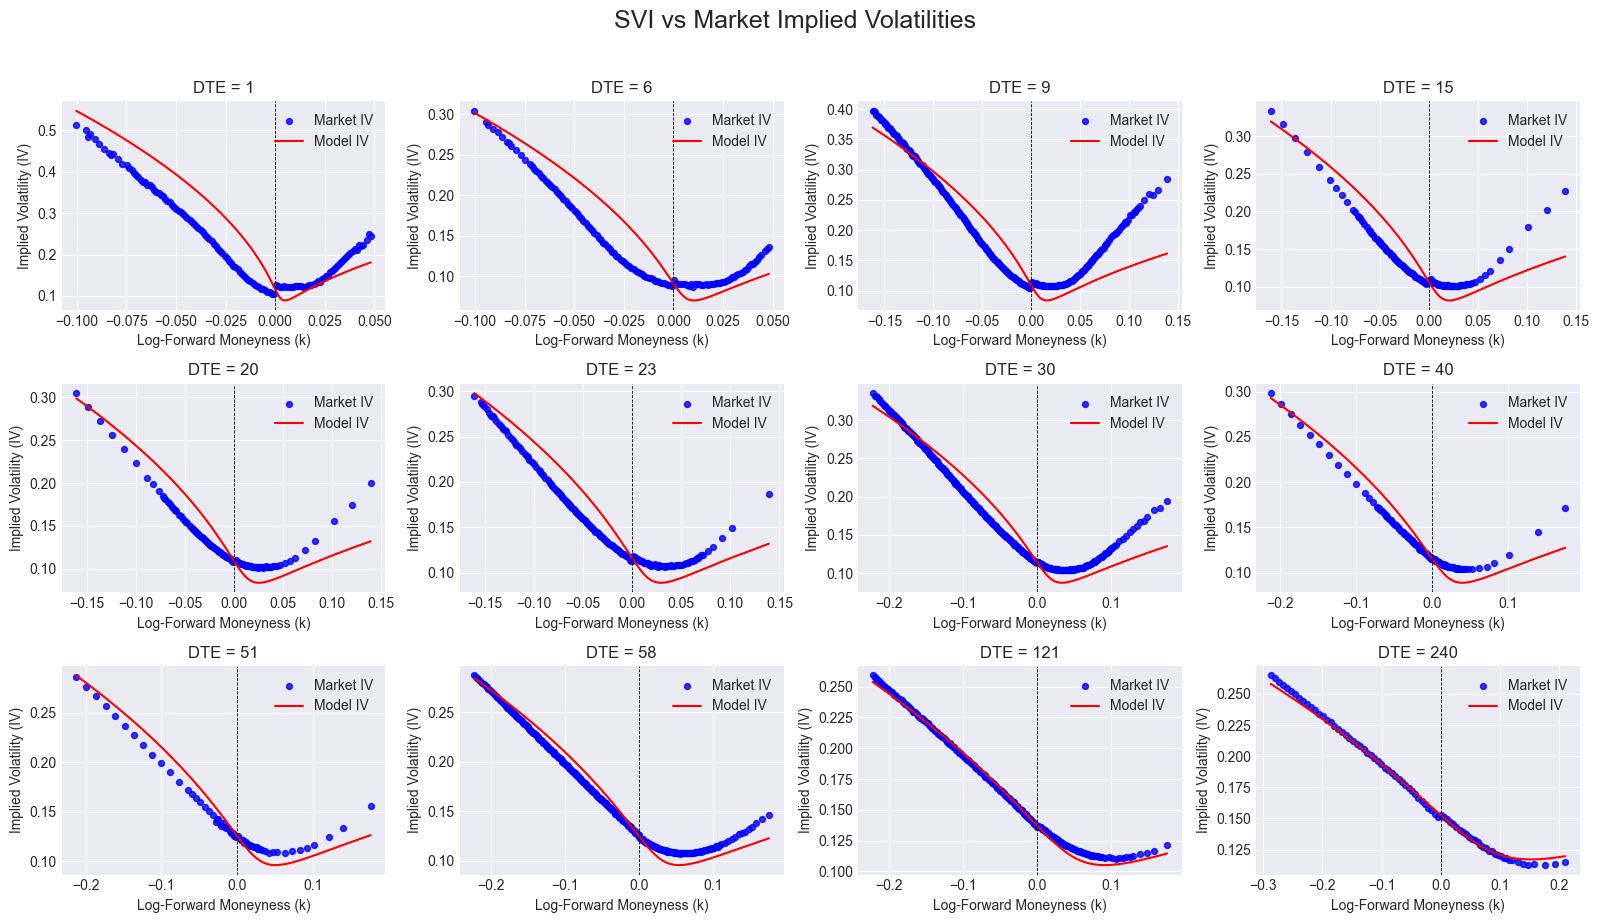

In [87]:
ssvi_unc.plot_smiles()

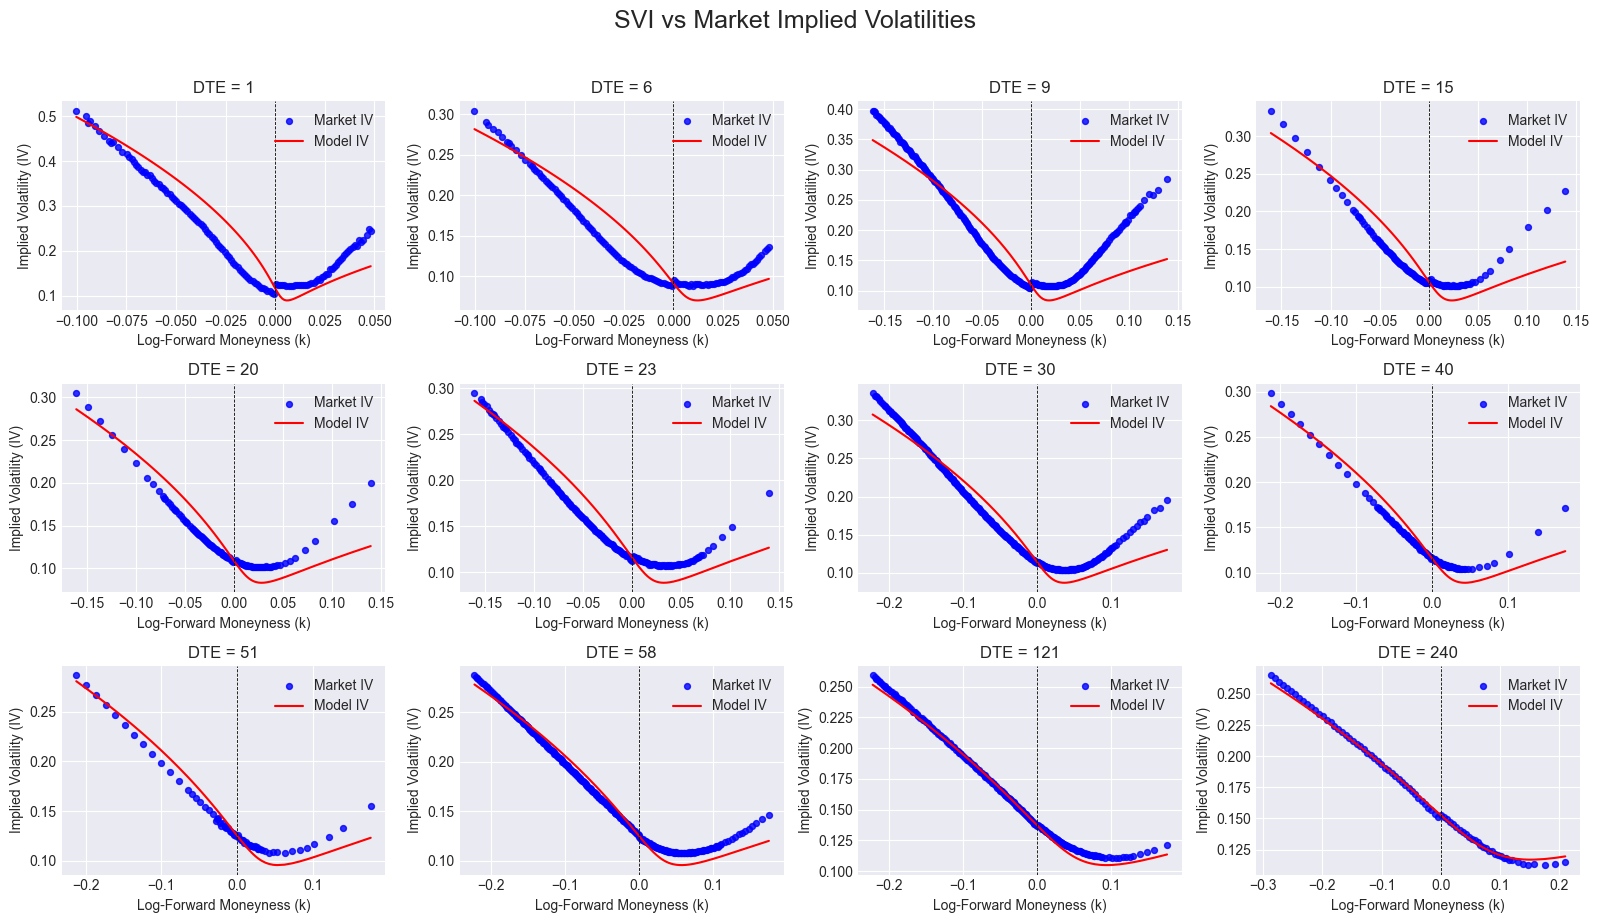

In [88]:
ssvi_butt_arb.plot_smiles()

In [89]:
ssvi_unc.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

In [90]:
ssvi_butt_arb.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

Despite enforcing a penalty for violating the sufficient condition, which results in a slightly worse fit, both approaches produce surfaces that do not violate either butterfly or calendar arbitrage.

### **5.1.2. Uniform vs ATM vs ATM-Theta Weighting**

As with SVI, we compare different weighting schemes designed to emphasize the most relevant quotes — typically near **At-The-Money (ATM)** and, in some cases, for **shorter maturities**.  
In the **ATM-Theta** scheme, we also use $\theta(T)$, which is monotonic in $T$, to further prioritize short maturities.

#### **1. Uniform weighting**  
   $$
   \omega(k, T) = 1
   $$
   All strikes and maturities are treated equally, with no preference for ATM or short-term quotes.

#### **2. ATM weighting**  
   $$
   \omega(k, T) = \frac{1}{|k| + 0.05}
   $$
   Places higher importance on ATM quotes, which tend to be more liquid and carry more reliable information.

#### **3. ATM-Theta weighting**  
   $$
   \omega(k, T) = \frac{1}{(|k| + 0.05) \cdot (\sqrt{\theta(T) + 10^{-8}})}
   $$
   Increases weight for ATM quotes **and** emphasizes shorter maturities (smaller $\theta$), which are more sensitive to local surface misfits.


In [91]:
ssvi_unif = SSVI(weight_mode="uniform")
ssvi_atm = SSVI(weight_mode="atm")
ssvi_atm_theta = SSVI(weight_mode="atm_theta")

ssvi_unif.fit(options_red)
ssvi_atm.fit(options_red)
ssvi_atm_theta.fit(options_red)

print(f"Pooled RMSE of IV with Uniform weighting: {round(ssvi_unif.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with ATM weighting: {round(ssvi_atm.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with ATM Theta weighting: {round(ssvi_atm_theta.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV with Uniform weighting: 3.03 %
Pooled RMSE of IV with ATM weighting: 3.00 %
Pooled RMSE of IV with ATM Theta weighting: 2.76 %


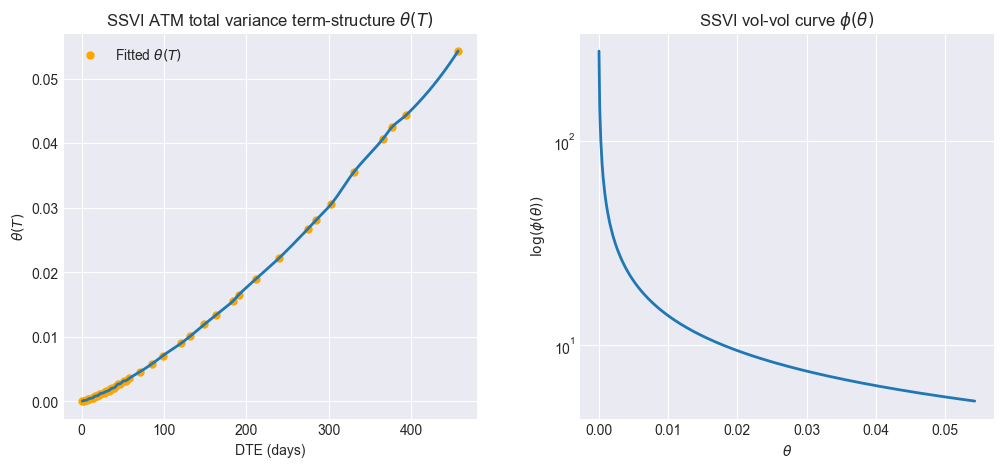

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.25})
ssvi_atm_theta.plot_theta(ax=axes[0])
ssvi_atm_theta.plot_phi(ax=axes[1])
plt.show()

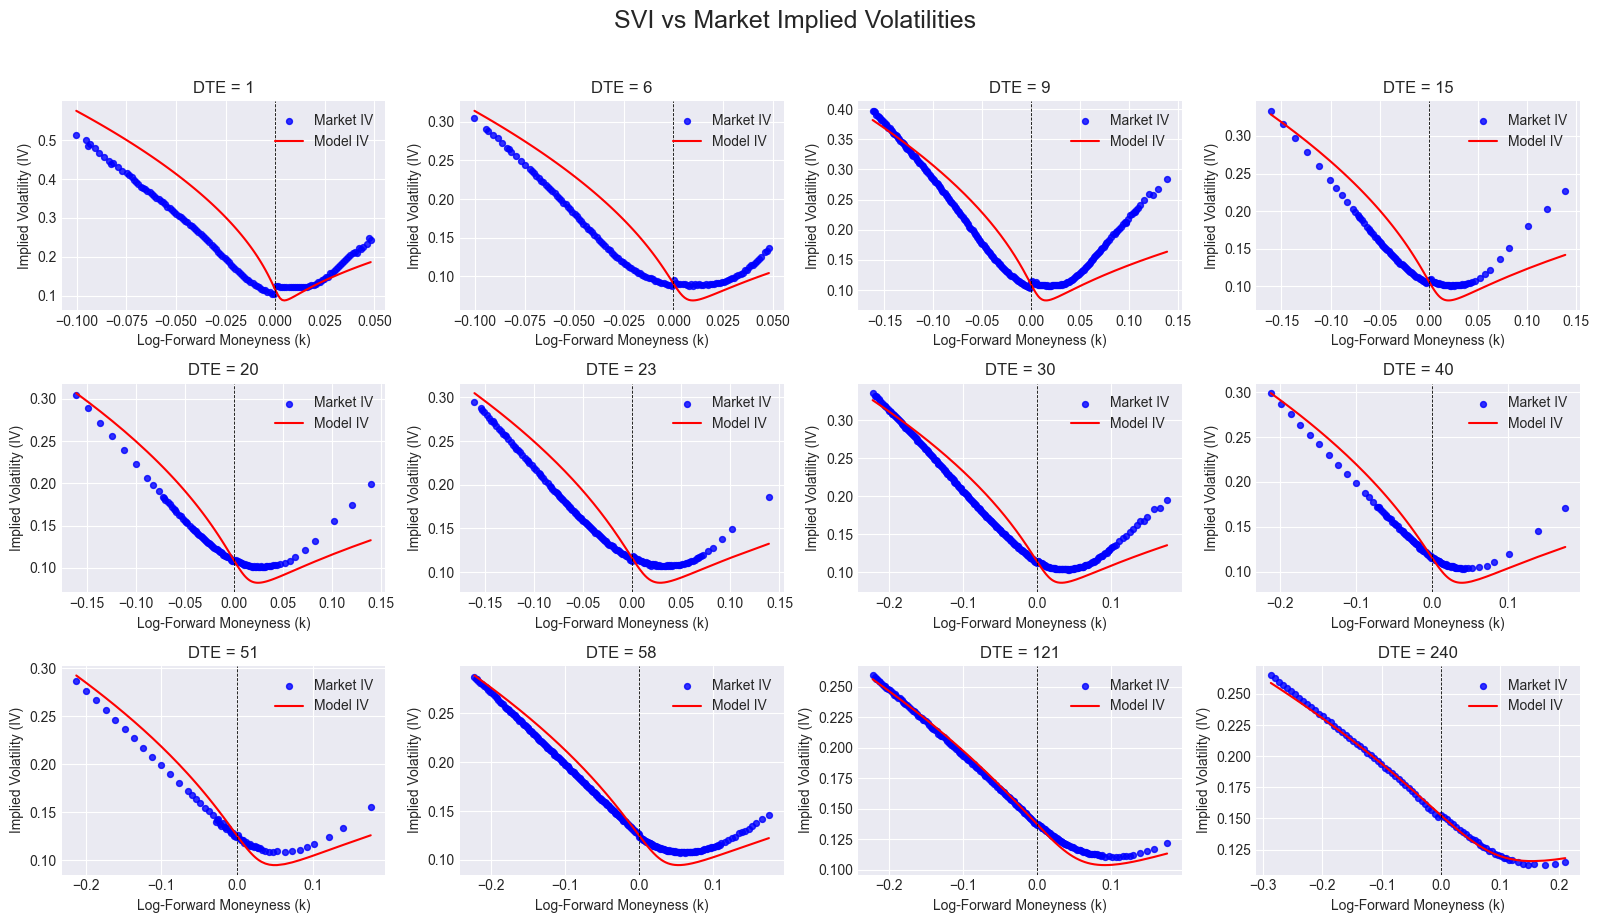

In [93]:
ssvi_unif.plot_smiles()

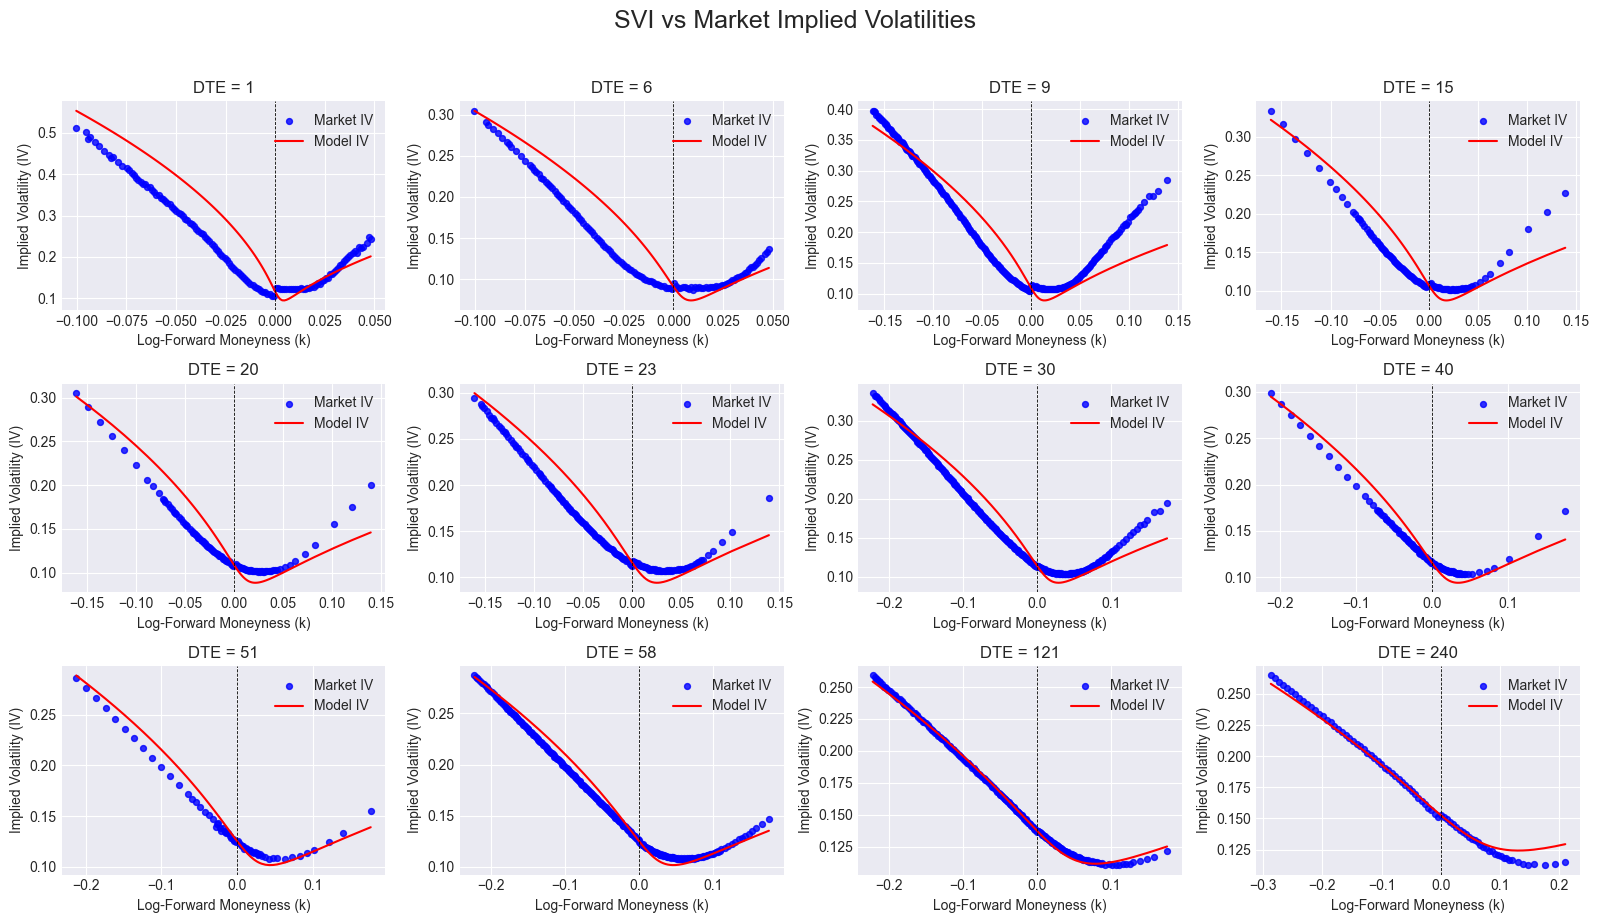

In [94]:
ssvi_atm_theta.plot_smiles()

The ATM theta weighting performs betetr across all strikes and maturities, except for very larger **240 DTE**.

In [95]:
ssvi_unif.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

In [96]:
ssvi_atm.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

In [97]:
ssvi_atm_theta.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

The resulting volatility surface is **free of static and calendar arbitrage**, but this comes at the cost of **poorer smile fits** due to the low-dimensional parameterization (only three parameters for the entire surface)

## **5.2. Extended-SSVI (eSSVI)**

The **eSSVI** model extends SSVI to improve the fit of **short-term expiry smiles** by relaxing the constant $\rho$ assumption and allowing $\rho$ to depend on maturity.  

Empirically, $\rho$ often **decreases with $T$** in index equity option smiles. eSSVI captures this behaviour by modelling $\rho$ as a function of the ATM total variance $\theta(T)$:  

$$
\rho(\theta) = \tanh\big( \alpha + \beta \, \theta \big),
$$

where $\alpha$ and $\beta$ are parameters controlling the level and slope of $\rho(\theta)$.  
The $\tanh$ function ensures that $\rho(\theta) \in (-1, 1)$, which is consistent with SVI no-arbitrage bounds.

This added flexibility improves short-term fits but makes it harder to ensure **calendar-arbitrage-free** surfaces.  
The **necessary and sufficient** conditions for SSVI no longer fully apply, and the original eSSVI calendar-arbitrage condition (Gatheral–Jacquier) has been shown to be flawed (Pasquazzi, 2023).  

For **butterfly arbitrage**, conditions (3) and (4) from SSVI remain valid, leading to bounds on $\eta$:  

$$
\eta \leq \frac{4}{\left( 1 + \rho_{\max} \right) \, \theta_{\max}^{\,1 - \gamma}}; \  \eta \leq \frac{2}{\sqrt{\left( 1 + \rho_{\max} \right) \, \theta_{\min}^{\,1 - 2\gamma}}}.
$$  

In [ ]:
class eSSVI(xSSVI):
    """
    eSSVI (extended SSVI) fit:
    w(k,T) = θ(T)/2 (1 + ρ(θ) φ(θ) k + sqrt((φ(θ) k + ρ(θ))^2 + 1 - ρ(θ)²))
    
    φ(θ) = η θ^{-γ}
    ρ(θ) = tanh(a + bθ)
    """
    def __init__(self, bounds=None, **kwargs):
        super().__init__(**kwargs)
        default_bounds = [
            (-3.0, 3.0),      # alpha (for _rho)
            (-10.0, 10.0),   # beta (for _rho)
            (1e-4, 2.0),    # eta (for _phi)
            (1e-3, 0.999)  # gamma (for _phi)
        ] 

        self.bounds = bounds or default_bounds

    # -------- kernel pieces --------
    @staticmethod
    def _phi(theta, eta, gamma):
        return eta * np.power(theta, -gamma)
    
    @staticmethod
    def _rho(theta, alpha, beta):
        # bounded in (-1,1), smooth, monotone if beta has a sign
        return np.tanh(alpha + beta * theta)

    @classmethod
    def _w(cls, k, theta, params):
        alpha, beta, eta, gamma = params
        rho = cls._rho(theta, alpha, beta)
        phi = cls._phi(theta, eta, gamma)
        return 0.5*theta * (1.0 + rho*phi*k + np.sqrt((phi*k + rho)**2 + 1.0 - rho**2))

    def _objective(self, k, theta, w, weights, params):
        alpha, beta, eta, gamma = params
        w_model = self._w(k, theta, params)
        sse = np.sum(weights * (w_model - w)** 2)

        # ---- soft butterfly arb penalties ----
        # cap by max rho and min/max theta:
        rho_all = self._rho(theta, alpha, beta)
        rho_max  = float(np.max(np.abs(rho_all)))
        theta_min, theta_max = np.min(theta), np.max(theta)
        eta_cap_3 = 4.0 / ((1.0 + rho_max) * theta_max**(1.0 - gamma))
        eta_cap_4 = 2.0 / np.sqrt((1.0 + rho_max) * theta_min**(1.0 - 2.0*gamma))
        eta_cap = min(eta_cap_3, eta_cap_4)

        if self.butterfly_arb_strict and eta >= eta_cap:
            sse += 1e8 * (eta - eta_cap)**2   # hinge penalty
            
        return sse
    
    def plot_rho(self, n: int = 200, ax=None):
        if self._last_market is None:
            raise RuntimeError("Call fit(...) first.")
        T_min = float(self._last_market["T"].min())
        T_max = float(self._last_market["T"].max())
        T_grid = np.linspace(T_min, T_max, n)
        theta = self.theta_interp(T_grid)
        alpha, beta, _, _ = self.params
        rho_vals = self._rho(theta, alpha, beta)

        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 4.5))

        ax.plot(theta, rho_vals, lw=2)
        ax.set_xlabel(r"$\theta$")
        ax.set_ylabel(r"$\rho(\theta)$")
        ax.set_title(r"eSSVI rho curve $\rho(\theta)$")
        return ax

### **5.2.1 Unconstrained vs Butterfly Penalty**

Here we enforce the butterfly sufficient conditions by adding a a penalty on the Hinge loss.

In [100]:
essvi_unc = eSSVI(butterfly_arb_strict=False)
essvi_butt_arb = eSSVI(butterfly_arb_strict=True)

essvi_unc.fit(options_red)
essvi_butt_arb.fit(options_red)

print(f"Pooled RMSE of IV without penalty: {round(essvi_unc.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with Butterfly penalty: {round(essvi_butt_arb.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV without penalty: 2.67 %
Pooled RMSE of IV with Butterfly penalty: 3.26 %


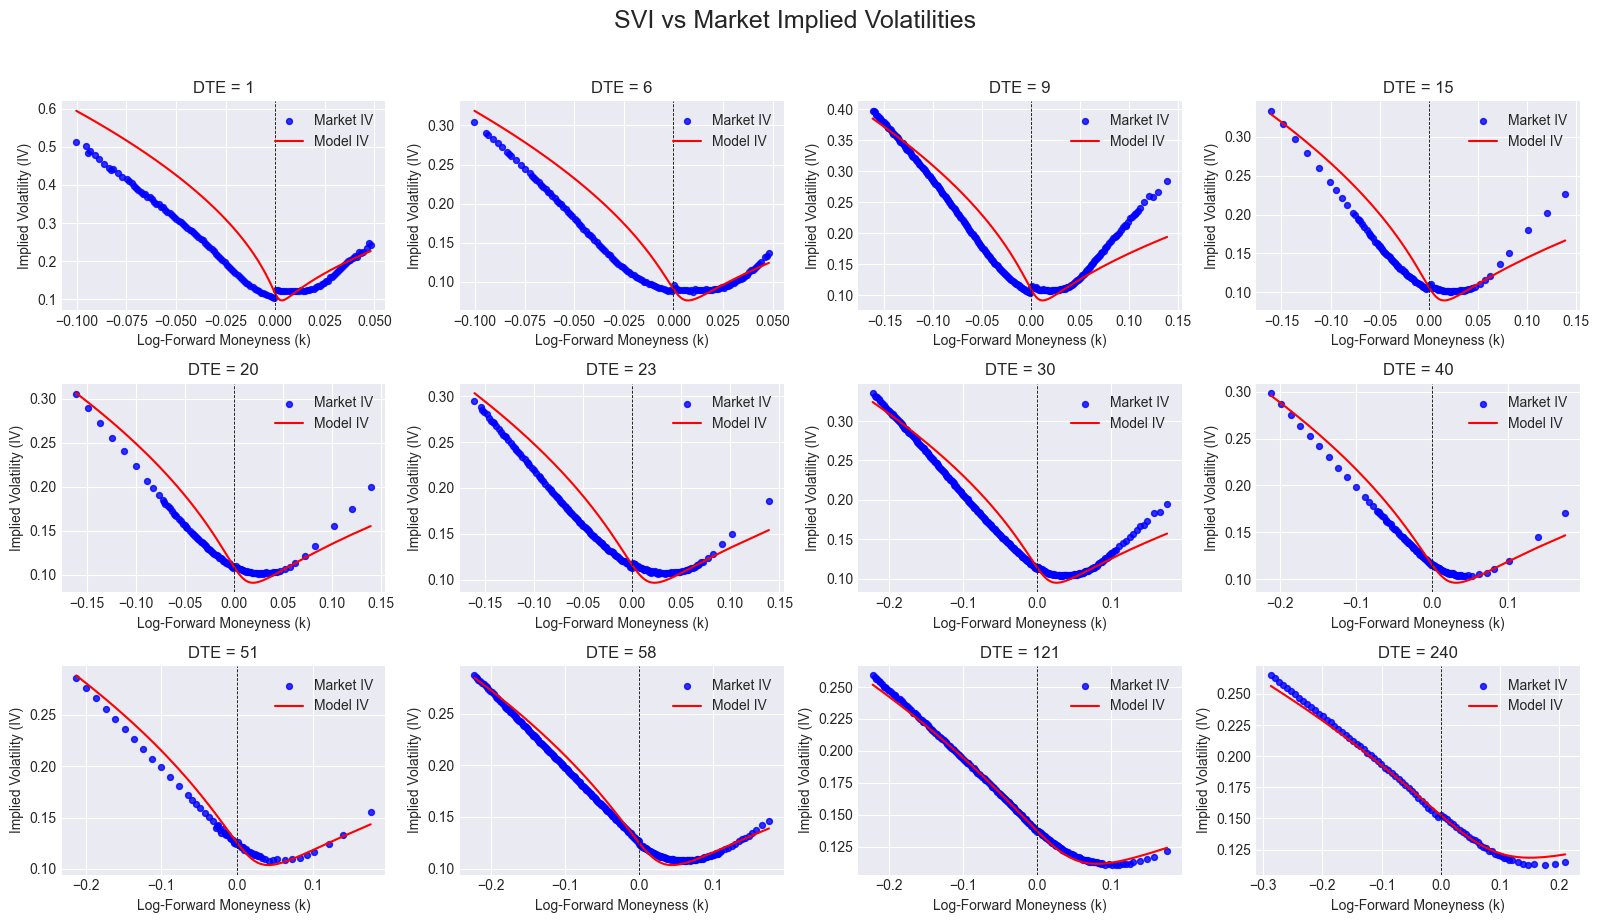

In [101]:
essvi_unc.plot_smiles()

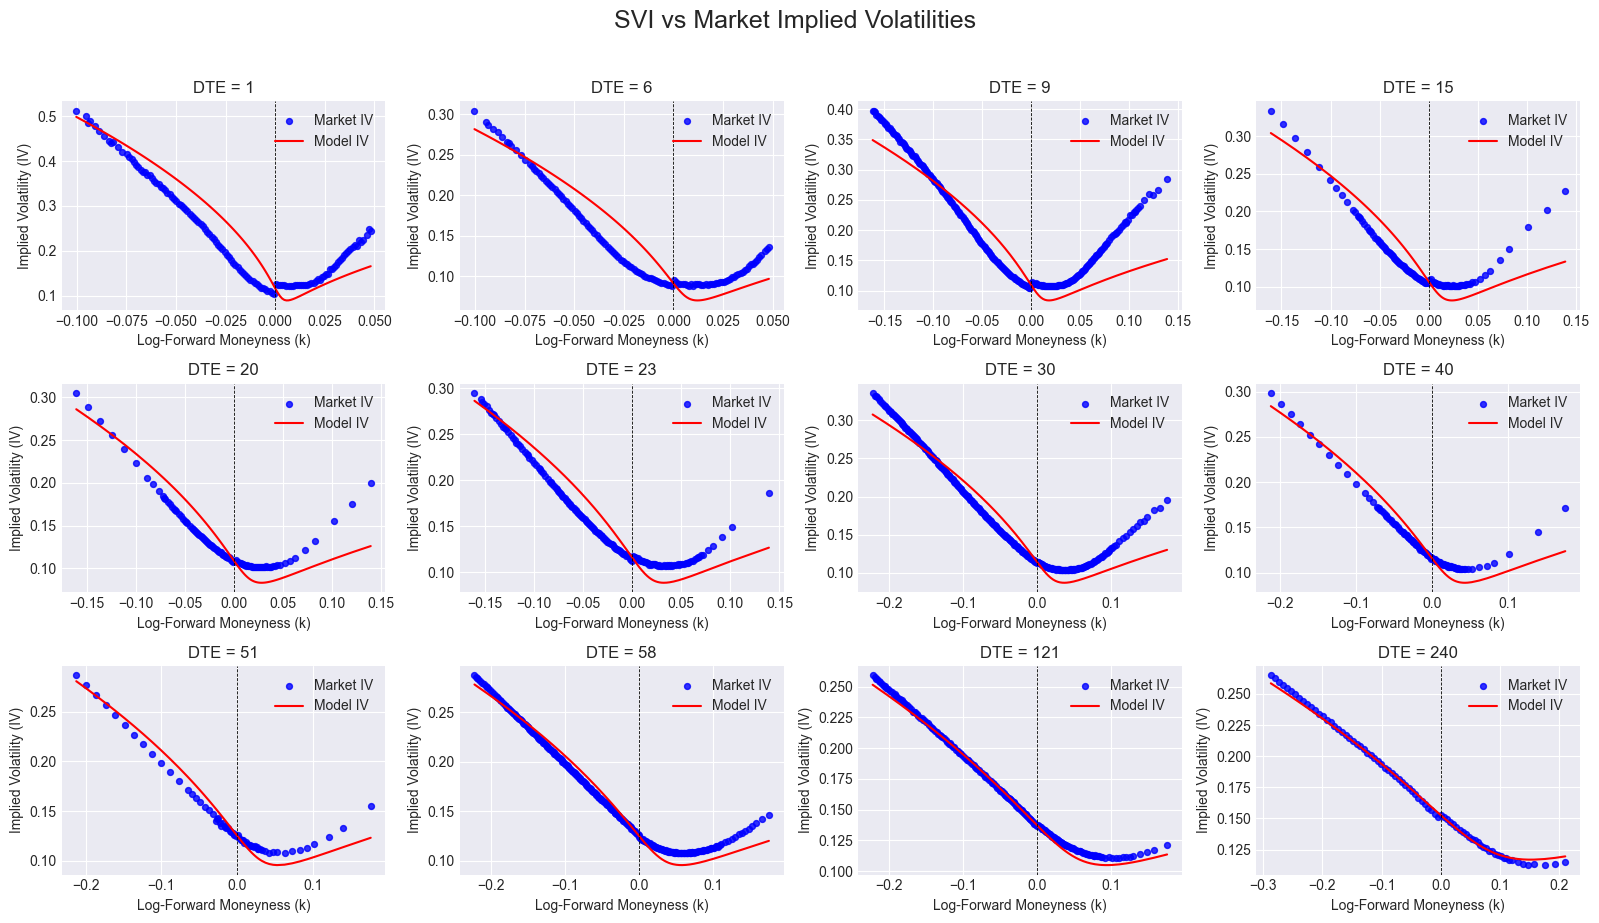

In [102]:
essvi_butt_arb.plot_smiles()

In [103]:
essvi_unc.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

In [104]:
essvi_butt_arb.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

With the **butterfly arbitrage penalty** active, the short-term fit quality deteriorates compared to the unconstrained case, even though **both configurations** (with and without the penalty) produce surfaces that are **butterfly-arbitrage-free**.

### **5.2.2. Uniform vs ATM vs ATM Theta Weighting**

We perform the same compariosn as we did previously with SVI and SSVI.

In [105]:
essvi_unif = eSSVI(weight_mode="uniform")
essvi_atm = eSSVI(weight_mode="atm")
essvi_atm_theta = eSSVI(weight_mode="atm_theta")

essvi_unif.fit(options_red)
essvi_atm.fit(options_red)
essvi_atm_theta.fit(options_red)

print(f"Pooled RMSE of IV with Uniform weighting: {round(essvi_unif.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with ATM weighting: {round(essvi_atm.pooled_rmse_iv(), 4)*100:.2f} %")
print(f"Pooled RMSE of IV with ATM Theta weighting: {round(essvi_atm_theta.pooled_rmse_iv(), 4)*100:.2f} %")

Pooled RMSE of IV with Uniform weighting: 2.82 %
Pooled RMSE of IV with ATM weighting: 2.67 %
Pooled RMSE of IV with ATM Theta weighting: 2.51 %


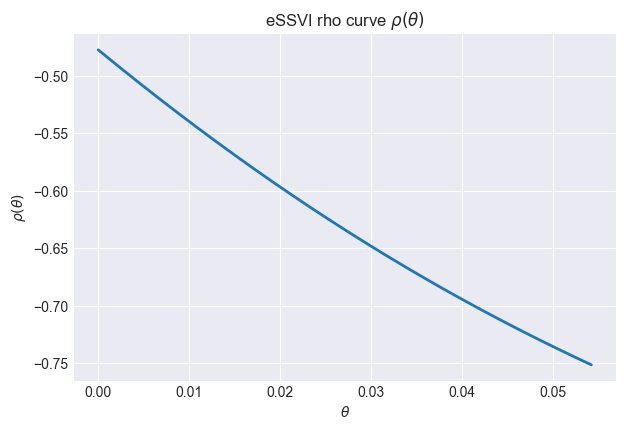

In [106]:
essvi_atm_theta.plot_rho()
plt.show()

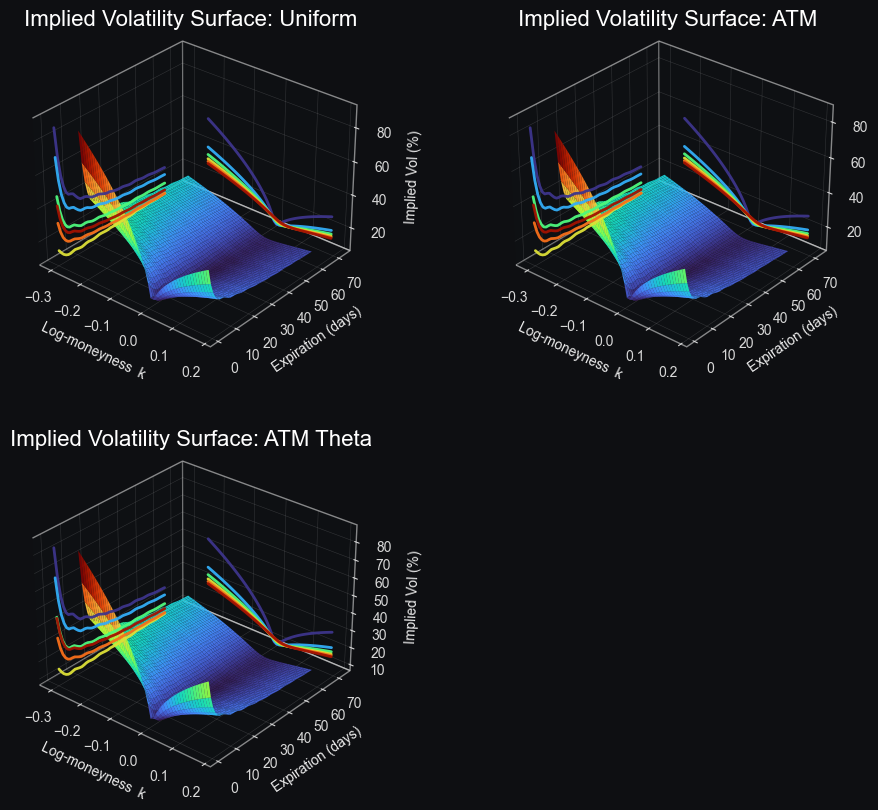

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10),
                         subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': 0.05}
)
fig.patch.set_facecolor("#0e0f12")
fig.delaxes(axes[1, 1])
essvi_unif.plot_iv_surface(ax=axes[0, 0], method_name='Uniform', colorbar=False)
essvi_atm.plot_iv_surface(ax=axes[0, 1], method_name='ATM', colorbar=False)
essvi_atm_theta.plot_iv_surface(ax=axes[1, 0], method_name='ATM Theta', colorbar=False)
plt.show()

In [108]:
essvi_unif.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

In [109]:
essvi_atm.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

In [110]:
essvi_atm_theta.check_arbitrage()

Empty DataFrame
Columns: [type, T, k, value]
Index: []

# **6. Conclusion**

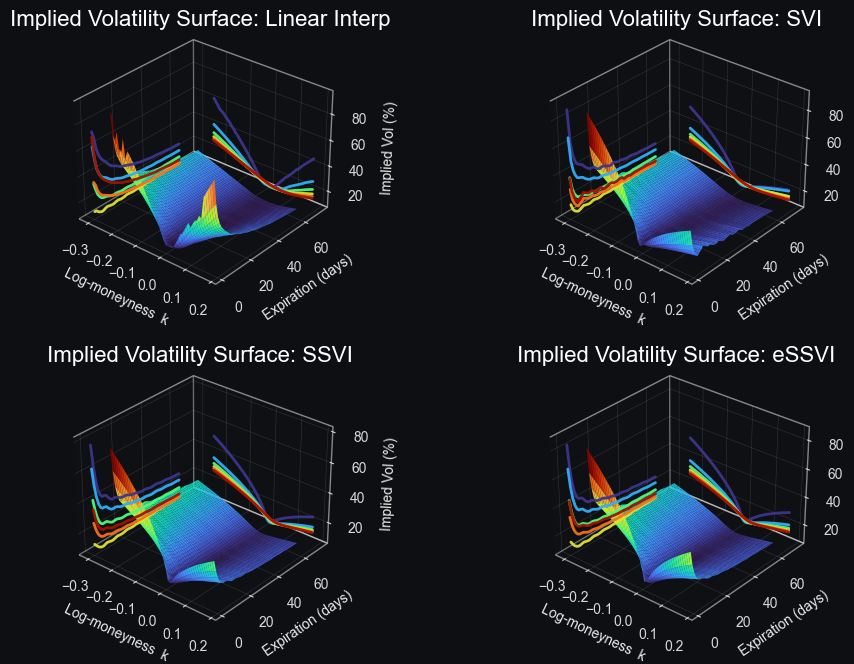

In [111]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8),
                         subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': 0.05}
)
fig.patch.set_facecolor("#0e0f12")
linear_interp.plot_iv_surface(ax=axes[0, 0], method_name='Linear Interp', colorbar=False)
svi_loc_fallback.plot_iv_surface(ax=axes[0, 1], method_name='SVI', colorbar=False)
ssvi_atm_theta.plot_iv_surface(ax=axes[1, 0], method_name='SSVI', colorbar=False)
essvi_atm_theta.plot_iv_surface(ax=axes[1, 1], method_name='eSSVI', colorbar=False)
plt.show()

# **7. References**

[1] Hendriks, S., & Martini, C. (n.d.). *The Extended SSVI Volatility Surface*.  
    Zeliade Systems, Paris; Delft University of Technology.

[2] Zeliade Systems. (2012, February). *Quasi-Explicit Calibration of Gatheral’s SVI Model*.  
    Zeliade White Paper.

[3] Corbetta, J., Cohort, P., Laachir, I., & Martini, C. (2019, March 5). *Robust Calibration and Arbitrage-Free Interpolation of SSVI Slices*.  
    Zeliade Systems, 56 rue Jean-Jacques Rousseau, Paris, France.

[4] Ferhati, T. (2020, March 15). *SVI Model Free Wings*.  

[5] Gatheral, J., & Jacquier, A. (2013, March 17). *Arbitrage-Free SVI Volatility Surfaces*.  
    Baruch College, City University of New York; Imperial College London.

[6] Pasquazzi, L. (2023). *A Note about Characterization of Calendar Spread Arbitrage in eSSVI Surfaces*.


## **TODO**

- Add slice fitting for SSVI and eSSVI to allow time varying parameters and thus improvign the fit.

- Add necessary and sufficient conditions for eSSVI

- Add get/set methods for single slice SVI and xSSV family